# Meta Analysis of the Datasets for the Epi² pilot project 
# PYTHON 3 Notebook
### Adrien Leger / EMBL EBI
### Starting date 23/05/2016

---
# Import general package and definition of specific functions

In [1]:
# pycl imports
from pycl import is_readable_file, is_gziped
from pycl import file_basename, file_extension, file_name, dir_name
from pycl import supersplit, rm_blank
from pycl import copyFile, gzip_file, gunzip_file
from pycl import head, linerange, colsum, fastcount, simplecount
from pycl import mkdir
from pycl import bash_basic, bash, make_cmd_str
from pycl import dict_to_md, dict_to_report
from pycl import reformat_table, _decompose_line, _clean_values, _reformat_line
from pycl import url_exist

#Std lib imports
import datetime
from glob import glob
from pprint import pprint as pp
from os.path import basename
from os import listdir, remove

# Third party import
import numpy as np
import scipy.stats as stats
import pylab as pl
from Bio import Entrez

#pyplot tweaking
%matplotlib inline
pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

In [2]:
# Specific helper functions

def generate_header (PMID, cell, modification, method):
    h = "# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver\n"
    h+= "# Maurits Evers (maurits.evers@anu.edu.au)\n"
    h+= "# Data cleaned and standardized. {}\n".format(str (datetime.datetime.today()))
    h+= "# Adrien Leger (aleg@ebi.ac.uk)\n"
    h+= "# RNA_modification={}|Cell_type={}|Analysis_method={}|Pubmed_ID={}\n".format(modification, cell, method, PMID)
    h+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"
    return h

def file_summary(file, separator=["\t", "|"], max_items=10):
    n_line = fastcount(file)
    print("Filename:\t{}".format(file))
    print("Total lines:\t{}\n".format(n_line))
    linerange(file, range_list=[[0,9],[n_line-5, n_line-1]])
    print(colsum(file, header=False, ignore_hashtag_line=True, separator=separator, max_items=max_items))

def distrib_peak_len (file, range=None, bins=50, normed=True):
    h = []
    for line in open (file):    
        if line[0] != "#":
            ls = line.split("\t")
            delta = abs(int(ls[1])-int(ls[2]))
            h.append(delta)
        h.sort()

    pl.hist(h,normed=normed, range=range, bins=bins)
    pl.show()

def pubmed_fetch(pmid):
    Entrez.email = 'your.email@example.com'
    handle = Entrez.efetch (db='pubmed', id=pmid, retmode='xml', )
    return Entrez.read(handle)[0]

def pmid_to_info(pmid):
    results = pubmed_fetch(pmid)
    try:
        title = results['MedlineCitation']['Article']['ArticleTitle']
    except (KeyError, IndexError) as E:
        title = "NA"
    try:
        first_name = results['MedlineCitation']['Article']['AuthorList'][0]['LastName']
    except (KeyError, IndexError) as E:
        first_name = "NA"
    try:
        Year = results['MedlineCitation']['Article']['ArticleDate'][0]['Year']
    except (KeyError, IndexError) as E:
        Year = "NA"
    try:
        Month = results['MedlineCitation']['Article']['ArticleDate'][0]['Month']
    except (KeyError, IndexError) as E:
        Month = "NA"
    try:
        Day = results['MedlineCitation']['Article']['ArticleDate'][0]['Day']
    except (KeyError, IndexError) as E:
        Day = "NA"
    
    d = {"title":title, "first_name":first_name, "Year":Year, "Month":Month, "Day":Day}
        
    return d

---
# RNA PTM DATASETS

**I collected datasets from different sources. The 2 big database containing Inosine edition RADAR and DARNED as well as all the datasets cited in the recent review about lncRNA and epitranscriptomics from Shaffik et al. In addition I also have 2 recent datasets for m1A and m6A/Am6A. All the datasets need to be carefully reviewed, reformated to BED6 format, converted to hg38 reference genome and reannotated with recent genecode annotations. See overview of the datasets in the table below**


|Modification|Article|Initial number of peaks found (Shafik et al)|Final number of peaks found|Number of peaks in lncRNA found (Shafik et al)|Number of uniq lncRNA (Shafik et al)|
|---|---|---|---|---|---|
|Inosine|Z Peng et al. Nat Biotechnol 30, 253-60 (2012)|22686 (22686)|21,111 |3382 (4425)|505 (846)|
|Inosine|M Sakurai et al. Genome Res 24, 522-34 (2014)|20482 (20482)|20,482 |2550 (3050)|319 (400)|
|m5C|S Hussain et al. Cell Rep 4, 255-61 (2013)|1084 (1084)|1,084 |107 (110)|39 (41)|
|m5C|V Khoddami et al. Nat Biotechnol 31, 458-64 (2013)|20553 (20533)|20,553 |1523 (1580)|39 (38)|
|m5C|JE Squires et al. Nucleic Acids Res 40, 5023-33 (2012)|10490 (10490)|10,490 |281 (1544)|112 (711)|
|m6A|D Dominissini et al. Nature 485, 201-6 (2012)|25918 (25776)|2,894 |115 (7397)|84 (6165)|
|m6A|KD Meyer et al. Cell 149, 1635-46 (2012)|4341 (4341)|4,341 |48 (57)|16 (20)|
|m6A and m6Am|B Linder et al. Nat Methods 12, 767-72 (2015)|15167 (NA)|15,167 |385 (NA)|168 (NA)|
|m1A|D Dominissini et al. Nature 530, 441-6 (2016)|32136 (NA)|19552 (HeLa:8873, HepG2:8550, HEK293:2129)|606 (NA)|338 (NA)|
|pseudouridylation|TM Carlile et al. Nature 515, 143-6 (2014)|8 (8)|8 |4 (4)|3 (3)|
|pseudouridylation|X Li et al. Nat Chem Biol 11, 592-7 (2015)|1489 (1489)|1,489 |48 (58)|44 (54)|
|pseudouridylation|S Schwartz et al. Cell 159, 148-62 (2014)|402 (396)|402 |14 (15)|10 (11)|
|Inosine|DARNED database|333216 (259654)|290,002 |24152 (23574)|1300 (1833)|
|Inosine|RADAR database|2576460 (2576289)|1,342,374 |97118 (218793)|3343 (6376)|

---
## DARNED

### Reformat DARNED Database

**The file dowloaded from DARNED is not a bed file. I need to modify it to comply with the standard format**

In [62]:
file_summary("./PTM_Original_Datasets/DARNED_human_hg19_all_sites.txt")

Filename:	./PTM_Original_Datasets/DARNED_human_hg19_all_sites.txt
Total lines:	333217

0	#DARNED  
1	#chrom	coordinate	strand	inchr	inrna	gene	seqReg	exReg	source	PubMed ID
2	4	250721	-	A	I		O		DIENCEPHALON	19478186
3	4	475468	-	A	I	ZNF721	I		THYMUS	15342557
4	4	476348	-	A	I	ZNF721	I		THYMUS	15342557
5	4	476410	-	A	I	ZNF721	I		THYMUS	15342557
6	4	476414	-	A	I	ZNF721	I		THYMUS	15342557
7	4	476424	-	A	I	ZNF721	I		THYMUS	15342557
8	4	476487	-	A	I	ZNF721	I		THYMUS	15342557
9	4	476489	-	A	I	ZNF721	I		THYMUS	15342557

333212	X	3737545	-	A	G	LOC389906	I		LYMPHOBLASTOID CELL	22484847
333213	X	3737714	-	A	G	LOC389906	I		LYMPHOBLASTOID CELL	22484847
333214	X	3737716	-	A	G	LOC389906	I		LYMPHOBLASTOID CELL	22484847
333215	X	3738584	-	G	T	LOC389906	I		LYMPHOBLASTOID CELL	22484847
333216	X	3738585	-	G	T	LOC389906	I		LYMPHOBLASTOID CELL	22484847

|0|1|2|12|3|7|5|6|4|8|19|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|50666|34880|28526|28318|28036|21071|19282|16767|15833|150

**DARNED is a little messy and hard to convert since the position with the same PMID/OR sample types where fused in the same Site. It makes it difficult to parse. I think it would be better if I duplicate the site with the several PMID and sample type. I just need to verify if the number of fields in PMID and cell type is similar and if they correspond to each other, ie first in cell type = first in PMID**

In [55]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

header = "# DARNED database Human all sites hg19 coordinates\n"
header+= "# Data cleaned, filtered for Inosine editing, standardized and converted to BED6 format\n"
header+= "# Adrien Leger (aleg@ebi.ac.uk) - {}\n".format(str (datetime.datetime.today()))
header+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

reformat_table(
    input_file = "./PTM_Original_Datasets/DARNED_human_hg19_all_sites.txt",
    output_file = "./PTM_Original_Datasets/DARNED_human_hg19_inosine.bed",
    init_template = [0,"\t",1,"\t",2,"\t",3,"\t",4,"\t",5,"\t",6,"\t",7,"\t",8,"\t",9],
    final_template = ["chr",0,"\t",1,"\t",1,"\t",3,">",4,"|",8,"|-|",9,"|",5,"\t0\t",2],
    keep_original_header = False,
    header = header,
    replace_internal_space = '_',
    replace_null_val = "-",
    filter_dict = {0:["-"],1:["-"],2:["?"],3:["T","G","C"],4:["C","T","A","U"],8:["-"],9:["-"]},
    subst_dict = {4:{"G":"I"}}
    )

file_summary("./PTM_Original_Datasets/DARNED_human_hg19_inosine.bed")

333215 Lines processed	285250 Lines pass	47965 Lines filtered out	0 Lines fail

Filename:	./DARNED/DARNED_human_hg19_inosine.bed
Total lines:	285254

0	# DARNED database Human all sites hg19 coordinates
1	# Data cleaned, filtered for Inosine editing, standardized and converted to BED6 format
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 11:23:04.068087
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr4	250721	250721	A>I|DIENCEPHALON|-|19478186|-	0	-
5	chr4	475468	475468	A>I|THYMUS|-|15342557|ZNF721	0	-
6	chr4	476348	476348	A>I|THYMUS|-|15342557|ZNF721	0	-
7	chr4	476410	476410	A>I|THYMUS|-|15342557|ZNF721	0	-
8	chr4	476414	476414	A>I|THYMUS|-|15342557|ZNF721	0	-
9	chr4	476424	476424	A>I|THYMUS|-|15342557|ZNF721	0	-

285249	chrX	3626805	3626805	A>I|LYMPHOBLASTOID_CELL|-|22484847|PRKX	0	-
285250	chrX	3737454	3737454	A>I|LYMPHOBLASTOID_CELL|-|22484847|LOC389906	0	-
285251	chrX	3737545	3737545	A>I|LYMPHOBLASTOID_CELL|-|22484847|LOC389906	0	-
285252	chrX	3737

**I reformated and filtered the database with reformat_table to be BED6 compatible. I removed the fields lacking either chromosome, position, tissue, and PID as well as with unknown strand. In addition I also selected only A>I and A>G transitions (same thing). This filtering step eliminated 47965 sites**

In [56]:
d={}

with open("./PTM_Original_Datasets/DARNED_human_hg19_inosine.bed", "r") as f:
    for line in f:
        if line [0] !="#":
            ls = supersplit(line, ["\t","|"])
            n_tissue = len(ls[4].split(","))
            n_PMID = len(ls[6].split(","))
            key="{}:{}".format(n_tissue,n_PMID)
            if key not in d:
                d[key]=0
            d[key]+=1

print (d)

{'5:2': 32, '4:4': 28, '3:4': 49, '1:4': 5, '7:2': 1, '8:4': 1, '6:1': 4, '2:2': 3125, '4:2': 52, '3:3': 215, '1:2': 4618, '3:2': 285, '3:5': 2, '2:4': 18, '5:5': 1, '5:1': 41, '4:3': 50, '6:4': 1, '1:1': 272551, '4:5': 1, '1:3': 181, '4:1': 47, '5:4': 5, '2:5': 1, '6:2': 4, '7:4': 2, '2:3': 386, '3:1': 185, '2:1': 3348, '5:3': 11}


**I tried to see if the PMID and the tissue field always had the same lengh, so I could de multiplex the fused positions. The answer is no, the number of PMID and tissues could be different. However 272551 positions have only 1 tissue and 1 PMID. These are maybe not the more relialable positions but they might be more easy to interprete. The sites with only 1 PMID but several tissues can also be used. Same think for several PMID, 1 tissue. I will demultiplex them so as to have only 1 PMID and 1 tissue by site. Concerning the site with more than 1 PMID and 1 tissue, I will extract then in another backup file.** 

In [57]:
infile = "./PTM_Original_Datasets/DARNED_human_hg19_inosine.bed"
outclean = "./PTM_Original_Datasets/DARNED_human_hg19_inosine_cleaned.bed"
outunclean = "./PTM_Original_Datasets/DARNED_human_hg19_inosine_unclean.bed"

with open(infile, "r") as inf, open(outclean, "w") as outf_clean, open(outunclean, "w") as outf_unclean:
    
    init_sites = uniq = several_tissue = several_pmid = several_all = final_sites = 0  
    
    for line in inf:
        if line [0] == "#":
            outf_clean.write(line)
            outf_unclean.write(line)
        else:
            init_sites += 1
            ls = supersplit(line, ["\t","|"])
            tissue_list = ls[4].split(",")
            PMID_list = ls[6].split(",")
            n_tissue = len(tissue_list)
            n_PMID = len(PMID_list)
            
            if n_tissue == 1:
                
                # 1 PMID, 1 tissue = no problem
                if n_PMID == 1:
                    uniq += 1
                    final_sites += 1
                    outf_clean.write(line)
                
                # Several PMID, 1 tissue = demultiplex PMID lines
                else:
                    several_pmid += 1
                    for PMID in PMID_list:
                        final_sites += 1
                        outf_clean.write("{0}\t{1}\t{2}\t{3}|{4}|{5}|{6}|{7}\t{8}\t{9}".format(
                            ls[0],ls[1],ls[2],ls[3],ls[4],ls[5],PMID.strip(),ls[7],ls[8],ls[9]))
            else:
                
                # 1 PMID, several tissues = demultiplex tissues lines
                if n_PMID == 1:
                    several_tissue += 1
                    for tissue in tissue_list:
                        final_sites += 1
                        outf_clean.write("{0}\t{1}\t{2}\t{3}|{4}|{5}|{6}|{7}\t{8}\t{9}".format(
                            ls[0],ls[1],ls[2],ls[3],tissue.strip().strip("_").strip("."),ls[5],ls[6],ls[7],ls[8],ls[9]))
                
                # Several PMID, several tissues = extract the line in uncleanable datasets
                else:
                    several_all += 1
                    outf_unclean.write(line)

print("Initial sites: ", init_sites)
print("Final clean sites: ", final_sites)
print("1 PMID 1 tissu: ", uniq)
print("1 PMID ++ tissue: ", several_tissue)
print("++ PMID 1 tissue: ", several_pmid)
print("++ PMID ++ tissue: ", several_all)

file_summary(outclean)
file_summary(outunclean)

Initial sites:  285250
Final clean sites:  290018
1 PMID 1 tissu:  272551
1 PMID ++ tissue:  3625
++ PMID 1 tissue:  4804
++ PMID ++ tissue:  4270
Filename:	./DARNED/DARNED_human_hg19_inosine_cleaned.bed
Total lines:	290022

0	# DARNED database Human all sites hg19 coordinates
1	# Data cleaned, filtered for Inosine editing, standardized and converted to BED6 format
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 11:23:04.068087
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr4	250721	250721	A>I|DIENCEPHALON|-|19478186|-	0	-
5	chr4	475468	475468	A>I|THYMUS|-|15342557|ZNF721	0	-
6	chr4	476348	476348	A>I|THYMUS|-|15342557|ZNF721	0	-
7	chr4	476410	476410	A>I|THYMUS|-|15342557|ZNF721	0	-
8	chr4	476414	476414	A>I|THYMUS|-|15342557|ZNF721	0	-
9	chr4	476424	476424	A>I|THYMUS|-|15342557|ZNF721	0	-

290017	chrX	3626805	3626805	A>I|LYMPHOBLASTOID_CELL|-|22484847|PRKX	0	-
290018	chrX	3737454	3737454	A>I|LYMPHOBLASTOID_CELL|-|22484847|LOC389906	0	-
290019	chrX	373754

**I only lost 4270 sites with several PMID and several tissue. Some sites where demultiplexed and I now have 290018 sites with 1 PMID and 1 tissue**

### Convert DARNED coordinates from hg19 to hg39 with Crossmap

**Coordinate conversion using CrossMap and a hg19 tp hg38 chain file in BASH**

In [58]:
# Conversion to hg38 with Crossmap/liftover
lifover_chainfile = "../LiftOver_chain_files/hg19ToHg38.over.chain.gz"
input_bed = "./PTM_Original_Datasets/DARNED_human_hg19_inosine_cleaned.bed"
temp_bed = "./PTM_Original_Datasets/DARNED_human_hg38_inosine_temp.bed"

cmd = "CrossMap.py bed {} {} {}".format(lifover_chainfile, input_bed, temp_bed)  
bash(cmd)

# Rewriting and updating of the header removed by Crossmap
final_bed = "./PTM_Original_Datasets/DARNED_human_hg38_inosine_cleaned.bed"

header = "# DARNED database Human all sites hg38 coordinates\n"
header+= "# Data cleaned, filtered for Inosine editing, standardized, converted to BED6 format and updated to hg38 coordinates\n"
header+= "# Adrien Leger (aleg@ebi.ac.uk) - {}\n".format(str (datetime.datetime.today()))
header+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

with open (temp_bed, "r") as infile, open (final_bed, "w") as outfile:
    outfile.write (header)
    for line in infile:
        outfile.write (line)

file_summary(final_bed)


@ 2016-06-09 11:27:48: Read chain_file:  ../LiftOver_chain_files/hg19ToHg38.over.chain.gz

Filename:	./DARNED/DARNED_human_hg38_inosine_cleaned.bed
Total lines:	290002

0	# DARNED database Human all sites hg38 coordinates
1	# Data cleaned, filtered for Inosine editing, standardized, converted to BED6 format and updated to hg38 coordinates
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 11:27:51.339572
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr4	256932	256932	A>I|DIENCEPHALON|-|19478186|-	0	-
5	chr4	481679	481679	A>I|THYMUS|-|15342557|ZNF721	0	-
6	chr4	482559	482559	A>I|THYMUS|-|15342557|ZNF721	0	-
7	chr4	482621	482621	A>I|THYMUS|-|15342557|ZNF721	0	-
8	chr4	482625	482625	A>I|THYMUS|-|15342557|ZNF721	0	-
9	chr4	482635	482635	A>I|THYMUS|-|15342557|ZNF721	0	-

289997	chrX	3708764	3708764	A>I|LYMPHOBLASTOID_CELL|-|22484847|PRKX	0	-
289998	chrX	3819413	3819413	A>I|LYMPHOBLASTOID_CELL|-|22484847|LOC389906	0	-
289999	chrX	3819504	3819504	A>I|LYMPHOBLASTO

**The conversion resulted in the lost of 16 sites, which is neglectable compared with the 290002 sites in the database**

---
## RADAR

### Reformat RADAR Database

**The file dowloaded from DARNED is not a bed file. I need to modify it to comply with the standard format. The format of the mane file *Human_AG_all_hg19_v2.txt* is the following: **

In [45]:
file_summary("./PTM_Original_Datasets/RADAR_human_hg19_v2_primary.txt", separator=["\t"])

Filename:	./RADAR/RADAR_human_hg19_v2_primary.txt
Total lines:	2576460

0	#chromosome	position	gene	strand	annot1	annot2	alu?	non_alu_repetitive?	conservation_chimp	conservation_rhesus	conservation_mouse
1	chr1	206256301	C1orf186	-	intronic	intronic	no	no	N	N	N
2	chr6	116991832	intergenic	-	intergenic	intergenic	no	no	N	N	N
3	chr7	30504355	NOD1	-	intronic	intronic	no	no	N	N	N
4	chr1	85127959	SSX2IP	-	Syn	Gln->Gln	no	no	N	N	N
5	chr15	100203261	MEF2A	+	intronic	intronic	no	no	N	N	N
6	chr6	102372915	GRIK2	+	intronic	intronic	no	no	N	N	N
7	chr9	135788925	TSC1	-	intronic	intronic	no	no	N	N	N
8	chr17	74414054	UBE2O	-	intronic	intronic	no	no	N	N	N
9	chr15	73069310	ADPGK	-	intronic	intronic	no	no	N	N	N

2576455	chr1	92591586	intergenic	-	intergenic	intergenic	no	no	N	N	N
2576456	chr1	92591608	intergenic	-	intergenic	intergenic	no	no	N	N	N
2576457	chr1	92591631	intergenic	-	intergenic	intergenic	no	no	N	N	N
2576458	chr1	92591653	intergenic	-	intergenic	intergenic	no	no	N	N	N
2576459	chr1	925916

**I am not interested by the conservation fields, the annotation and the repetitive nature, but I will keep chromosome, position, gene and strand.**
**Additional information is also available in a secondary database file that I found hidden on RADAR website. The information includes the original publication and the source of the biological sample. The information is only available for around half of the sites from 4 publications. I will only retain these richly annotated sites. The same sites can have bmultiple entries in the secondary file since I could have been reported by several papers in several tissues. I will keep a line for each independantly discovered site. The coverage and editing level could be interesting to save too.**

In [46]:
file_summary("./PTM_Original_Datasets/RADAR_human_hg19_v2_secondary.txt")

Filename:	./RADAR/RADAR_human_hg19_v2_secondary.txt
Total lines:	1343465

0	#location	reference	tissue	coverage	editing_level(%)
1	chr1:1037916	Peng et al 2012	Lymphoblastoid cell line	9	66.67
2	chr1:1156882	Peng et al 2012	Lymphoblastoid cell line	42	36.59
3	chr1:1157460	Peng et al 2012	Lymphoblastoid cell line	66	22.73
4	chr1:1252441	Peng et al 2012	Lymphoblastoid cell line	11	72.73
5	chr1:1252443	Peng et al 2012	Lymphoblastoid cell line	11	45.45
6	chr1:1253357	Peng et al 2012	Lymphoblastoid cell line	31	32.26
7	chr1:1253944	Peng et al 2012	Lymphoblastoid cell line	28	46.43
8	chr1:1418532	Peng et al 2012	Lymphoblastoid cell line	5	60.00
9	chr1:1419773	Peng et al 2012	Lymphoblastoid cell line	10	60.00

1343460	chrX:119056591	Bahn et al 2012	U87 cell line	5	60
1343461	chrX:123047295	Bahn et al 2012	U87 cell line	17	71
1343462	chrX:135300016	Bahn et al 2012	U87 cell line	9	55
1343463	chrX:153702725	Bahn et al 2012	U87 cell line	15	33
1343464	chrX:153702725	Bahn et al 2012	U87 cell line	

**The operation is quite complex since I will have to fuse the 2 files and extract only specific values. I need to code a specific parser. The main RADAR file will be parsed and organised as a simple embed dict. The secondary file will be the more important since I will start parsing from it to find the complementary information in the main database file. Each site will be added to a list of Site objects, that will be subsequently iterated to combine with the main database before writing in a new Bed formated file.**

In [108]:
# Create a structured dict of dict to parse the main database file
from collections import OrderedDict

def parse_RADAR_main (file):
    
    # Define the top level access dict
    radar_dict = OrderedDict() 
    
    for line in open (file, "r"):
        if line[0] != "#":
            
            sl = line.split("\t")

            assert len(sl) == 11      
            chromosome, position, gene, strand = sl[0].strip(), int(sl[1].strip()), sl[2].strip(), sl[3].strip()

            if chromosome not in radar_dict:
                radar_dict[chromosome] = OrderedDict()

            # There should be only one line per position
            assert position not in radar_dict[chromosome]
            radar_dict[chromosome][position] = {"gene":gene,"strand":strand}
    
    return radar_dict
        

In [109]:
# Create a class to store a line of the additional file.

from collections import OrderedDict

class Site (object):
    
    #~~~~~~~CLASS FIELDS~~~~~~~#
    # Table of correspondance reference => PMID
    TITLE_TO_PMID = {
        "Peng et al 2012":"22327324",
        "Bahn et al 2012":"21960545",
        "Ramaswami et al 2012":"22484847",
        "Ramaswami et al 2013":"23291724",
        }
    
    # Table of correspondance reference => PMID
    TISSUE_TO_SAMPLE = {
        "Brain":"Brain",
        "Illumina Bodymap":"Illumina_Bodymap",
        "Lymphoblastoid cell line":"YH",
        "U87 cell line":"U87MG"
        }

    #~~~~~~~FONDAMENTAL METHODS~~~~~~~#
    # Parse a line of the aditional information file
    def __init__(self, line, ):
        sl = line.strip().split("\t")
        
        self.chromosome = sl[0].split(":")[0].strip()
        self.position = int(sl[0].split(":")[1].strip())
        self.PMID = self.TITLE_TO_PMID[sl[1].strip()]
        self.tissue = self.TISSUE_TO_SAMPLE[sl[2].strip()]
        self.coverage = sl[3].strip()
        self.editing_level = sl[4].strip()
    
    # Fundamental class methods str and repr
    def __repr__(self):
        msg = "SITE CLASS\n"
        # list all values in object dict in alphabetical order
        keylist = [key for key in self.__dict__.keys()]
        keylist.sort()
        for key in keylist:
            msg+="\t{}\t{}\n".format(key, self.__dict__[key])
        return (msg)

    def __str__(self):
        return self.__repr__()

In [110]:
a = Site("chr1:1037916	Peng et al 2012	Lymphoblastoid cell line	9	66.67")
print (a)

SITE CLASS
	PMID	22327324
	chromosome	chr1
	coverage	9
	editing_level	66.67
	position	1037916
	tissue	YH



In [111]:
# Create a structured dict of dict to parse the secondary database file
def parse_RADAR_secondary (file):
    
    # Define a list to store Site object (not a dict because of redundancy)
    radar_list = []
    
    for line in open (file, "r"):
        if line[0] != "#":
            radar_list.append(Site(line))
    
    # return a list sorted by chromosome and positions
    return sorted(radar_list, key=lambda Site: (Site.chromosome, Site.position))

**Read the original file, reformat the field and write a new file BED6 compliant.**

    chrom	chromstart	chromend	name	score	orient
    chr4	774138	774138	A>I|LOC100129917|LUNG:LYMPHOBLASTOID_CELL_LINE|15342557:15258596:22327324	0	-

In [112]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"


def reformat_RADAR (main_file, secondary_file, outfile, errfile, header):

    # Read and structure the 2 database files
    print("Parse the main database file")
    main = parse_RADAR_main(main_file)

    print("Parse the secondary database file")
    secondary = parse_RADAR_secondary (secondary_file)

    print("Combine the data together in a new bed formated file")
    with open (outfile, "w+") as csvout, open (errfile, "w+") as errout:
        
        # rewrite header
        csvout.write(header)

        fail = success = 0
        for total, site in enumerate(secondary):

            try:
                line = "{0}\t{1}\t{1}\t{2}|{3}|{4}|{5}|{6}\t{7}\t{8}\n".format(
                    site.chromosome,
                    site.position,
                    "A>I",
                    site.tissue,
                    "-",
                    site.PMID,
                    main[site.chromosome][site.position]["gene"],
                    site.editing_level,
                    main[site.chromosome][site.position]["strand"],
                )
                csvout.write(line)
                success += 1

            except KeyError as E:
                line = "{0}\t{1}\t{2}\t{3}\t{4}\n".format(
                    site.chromosome,
                    site.position,
                    site.tissue,
                    site.PMID,
                    site.editing_level
                )
                errout.write(line)
                fail += 1       

    print ("{} Sites processed\t{} Sites pass\t{} Sites fail".format(total, success, fail))

In [113]:
header = "# RADAR database Human v2 all sites hg19 coordinates\n"
header+= "# Data cleaned, standardized and converted to BED6 format\n"
header+= "# Adrien Leger (aleg@ebi.ac.uk) - {}\n".format(str (datetime.datetime.today()))
header+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

reformat_RADAR(
    main_file = "./PTM_Original_Datasets/RADAR_human_hg19_v2_primary.txt",
    secondary_file = "./PTM_Original_Datasets/RADAR_human_hg19_v2_secondary.txt",
    outfile = "./PTM_Original_Datasets/RADAR_Human_hg19_inosine_cleaned.bed",
    errfile = "./PTM_Original_Datasets/RADAR_Human_hg19_inosine_orphan.bed",
    header = header)

file_summary("./PTM_Original_Datasets/RADAR_Human_hg19_inosine_cleaned.bed")

Parse the main database file
Parse the secondary database file
Combine the data together in a new bed formated file
1343463 Sites processed	1342423 Sites pass	1041 Sites fail
Filename:	./RADAR/RADAR_Human_hg19_inosine_cleaned.bed
Total lines:	1342427

0	# RADAR database Human v2 all sites hg19 coordinates
1	# Data cleaned, standardized and converted to BED6 format
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 12:08:57.833547
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr1	651206	651206	A>I|YH|-|22484847|RP5-857K21.4	40	-
5	chr1	666265	666265	A>I|YH|-|22484847|uc009vjm.2	16.7	-
6	chr1	666266	666266	A>I|YH|-|22484847|uc009vjm.2	16.7	-
7	chr1	676236	676236	A>I|YH|-|22484847|uc002khh.2	19.4	-
8	chr1	676236	676236	A>I|YH|-|23291724|uc002khh.2	13	-
9	chr1	676236	676236	A>I|Brain|-|23291724|uc002khh.2	15	-

1342422	chrY	23457758	23457758	A>I|YH|-|22484847|intergenic	18.8	-
1342423	chrY	23475581	23475581	A>I|YH|-|22484847|intergenic	50	+
1342424	chrY	2347559

**After combining information, out of the 1343463 sites in the RADAR secondary file and 2576460 in the RADAR primary file, 1342423 consistant sites were found in both files, ie half of the database site were filtered out because they where not in the 2 database files.**

### Convert RADAR coordinates from hg19 to hg39 with Crossmap

Coordinate conversion using CrossMap in BASH

In [114]:
# Conversion to hg38 with Crossmap/liftover
lifover_chainfile = "../LiftOver_chain_files/hg19ToHg38.over.chain.gz"
input_bed = "./PTM_Original_Datasets/RADAR_Human_hg19_inosine_cleaned.bed"
temp_bed = "./PTM_Original_Datasets/RADAR_Human_hg38_inosine_temp.bed"

cmd = "CrossMap.py bed {} {} {}".format(lifover_chainfile, input_bed, temp_bed)  
bash(cmd)

# Rewriting and updating of the header removed by Crossmap
final_bed = "./PTM_Original_Datasets/RADAR_Human_hg38_inosine_cleaned.bed"

header = "# RADAR database Human v2 all sites hg38 coordinates\n"
header+= "# Data cleaned, standardized, converted to BED6 format and updated to hg38 coordinates\n"
header+= "# Adrien Leger (aleg@ebi.ac.uk) - {}\n".format(str (datetime.datetime.today()))
header+= "# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

with open (temp_bed, "r") as infile, open (final_bed, "w") as outfile:
    outfile.write (header)
    for line in infile:
        outfile.write (line)

file_summary(final_bed)


@ 2016-06-09 12:09:43: Read chain_file:  ../LiftOver_chain_files/hg19ToHg38.over.chain.gz

Filename:	./RADAR/RADAR_Human_hg38_inosine_cleaned.bed
Total lines:	1342378

0	# RADAR database Human v2 all sites hg38 coordinates
1	# Data cleaned, standardized, converted to BED6 format and updated to hg38 coordinates
2	# Adrien Leger (aleg@ebi.ac.uk) - 2016-06-09 12:09:56.855643
3	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
4	chr1	715826	715826	A>I|YH|-|22484847|RP5-857K21.4	40	-
5	chr1	730885	730885	A>I|YH|-|22484847|uc009vjm.2	16.7	-
6	chr1	730886	730886	A>I|YH|-|22484847|uc009vjm.2	16.7	-
7	chr1	740856	740856	A>I|YH|-|22484847|uc002khh.2	19.4	-
8	chr1	740856	740856	A>I|YH|-|23291724|uc002khh.2	13	-
9	chr1	740856	740856	A>I|Brain|-|23291724|uc002khh.2	15	-

1342373	chrY	21295872	21295872	A>I|YH|-|22484847|intergenic	18.8	-
1342374	chrY	21313695	21313695	A>I|YH|-|22484847|intergenic	50	+
1342375	chrY	21313713	21313713	A>I|YH|-|22484847|intergenic	50	+
1342376	c

**Around 10000 additional sites were lost during the conversion from hg19 to hg38**

---
## Shafik et al datasets

### File list and define basic exploratory functions

**The datasets a pretty cleaned and already converted to hg38 build coordinates. However, they are not strandardize and the synthax could be different since the bioinformatician in charge of the analysis tried to keep as much information as possible from the original datasets. I will strandardize the file names, the bed name fields and add reformat the file header. In addition I will explore the datasets to see if the are consistant and decide if I use them or not.**

In [35]:
listdir("./PTM_Original_Datasets/")

['m6A_Meyer_hg38.bed',
 'editing_Sakurai_hg38.bed',
 'pseudoU_Li_hg38.bed',
 'DARNED_human_hg19_inosine.bed',
 'MeRIPseq_m1A_Dominissini2016_hg38.bed',
 'm5C_Khoddami_hg38.bed',
 'DARNED_human_hg19_all_sites.txt',
 'pseudoU_Carlile_hg38.bed',
 'RADAR_Human_hg38_inosine_temp.bed.unmap',
 'miCLIP_m6A_Linder2015_hg38.bed',
 'm5C_Hussain_hg38.bed',
 'RADAR_Human_hg19_inosine_cleaned.bed',
 'pseudoU_Schwartz_hg38.bed',
 'DARNED_human_hg38_inosine_cleaned.bed',
 'm6A_Dominissini_hg38.bed',
 'RADAR_Human_hg19_inosine_orphan.bed',
 'RADAR_Human_hg38_inosine_temp.bed',
 'editing_Peng_hg38.bed',
 'RADAR_Human_hg38_inosine_cleaned.bed',
 'DARNED_human_hg19_inosine_cleaned.bed',
 'RADAR_human_hg19_v2_secondary.txt',
 'RADAR_human_hg19_v2_primary.txt',
 'm5C_Squires_hg38.bed',
 'DARNED_human_hg19_inosine_unclean.bed',
 'DARNED_human_hg38_inosine_temp.bed',
 'DARNED_human_hg38_inosine_temp.bed.unmap']

---
### editing_Peng_hg38

In [5]:
infile="./PTM_Original_Datasets/editing_Peng_hg38.bed"
PMID = "22327324"
cell = "YH"
modification = "A>I"
method = "A_to_I_editing"
author = "Peng"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/editing_Peng_hg38.bed
Total lines:	22692

0	# Transcriptome-wide map of editing sites [hg38 coordinates]
1	# Reference: Peng et al., Nat. Biotechnol. 30, 253 (2012) [PMID 22327324, DOI 10.1038/nbt.2122]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	1102535	1102536	Peng|chr1|1027779|-|T|Y|A->G|66.67%|37|C|6|T|3|9|intron|C1orf159	0	-
7	chr1	1221501	1221502	Peng|chr1|1146745|-|T|Y|A->G|36.59%|99|T|26|C|15|42|intron|SDF4	0	-
8	chr1	1222079	1222080	Peng|chr1|1147323|-|T|Y|A->G|22.73%|94|T|51|C|15|66|intron|SDF4	0	-
9	chr1	1251840	1251841	Peng|chr1|1177084|-|T|Y|A->G|56.25%|99|C|9|T|7|16|intergenic|-	0	-

22687	chrY	21272330	21272331	Peng|chrY|21843605|-|T|Y|A->G|58.33%|62|C|7|T|5|12|intergenic|-	0	-
22688	chrY	21272371	21272372	Peng|chrY|21843646|-|T|Y|A->G|81.48%|49|C|22|T|5|27|intergenic|-	0	-
22689	chrY	21288231	21288232	Peng|chrY|21859506|-|T|

In [5]:
print(colsum(infile, colrange=[9], header=False, ignore_hashtag_line=True, separator=["\t", "|"], max_items=20, ret_type="report"))

First line found
9
	A->G	21111
	T->C	715
	G->A	236
	C->T	195
	T->G	69
	C->G	61
	G->C	56
	A->C	53
	T->A	51
	C->A	49
	G->T	45
	A->T	45



**The column 9 contains more than just Inosine transitions(A>G) but also all the other editing sites they found. Here I will focuss on the Inosine only. I need to filter out all the other values** 

In [61]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"|",6,"|",7,"|",8,"|",9,"|",10,"%|",11,"|",12,"|",13,"|",14,"|",15,"|",16,"|",17,"|",18,"\t",19,"\t",20]
final_template=[0,"\t",1,"\t",2,"\t",9,"|",cell,"|",method,"|",PMID,"|",18,"\t",10,"\t",20]

# filter out all but A>G transition which are Inosine transition
filter_dict={9:["T->C","G->A","C->T","T->G","C->G","G->C","A->C","T->A","C->A","G->T","A->T"]}

# Reformat the field value A->G to A>I for standardization 
subst_dict={9:{"A->G":"A>I"}}


reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-",
    subst_dict = subst_dict,
    filter_dict = filter_dict )

file_summary(outfile)

22686 Lines processed	21111 Lines pass	1575 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Datasets/Peng_A>I_YH_hg38_cleaned.bed
Total lines:	21117

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-09 16:51:42.099109
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=A>I|Cell_type=YH|Analysis_method=A_to_I_editing|Pubmed_ID=22327324
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	1102535	1102536	A>I|YH|A_to_I_editing|22327324|C1orf159	66.67	-
7	chr1	1221501	1221502	A>I|YH|A_to_I_editing|22327324|SDF4	36.59	-
8	chr1	1222079	1222080	A>I|YH|A_to_I_editing|22327324|SDF4	22.73	-
9	chr1	1251840	1251841	A>I|YH|A_to_I_editing|22327324|-	56.25	-

21112	chrY	21272330	21272331	A>I|YH|A_to_I_editing|22327324|-	58.33	-
21113	chrY	21272371	21272372	A>I|YH|A_to_I_editing|22327324|-	81.48	-
21114	chrY	21288231	21288232	A>I|YH|A_to_I_edit

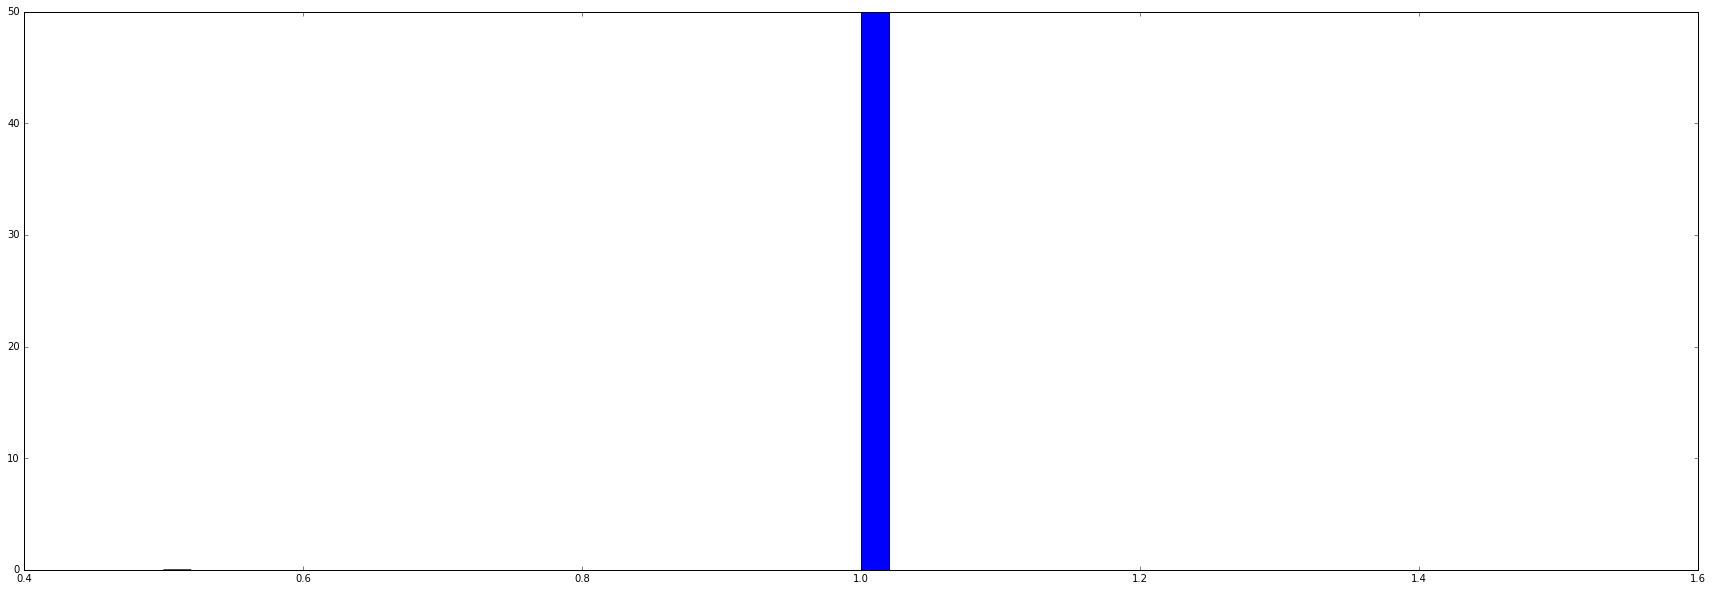

In [17]:
distrib_peak_len(outfile)

**Contains a lot of fields, some of which I don't even have an idea of what the contains. The dataset was not filtered and contains not only A>G A>I transitions. There is a total of 22686 sites but only 21111 are A>G transitions. I filtered out all the other modifications and retained only the A>G transition.**

**I am not sure that I should use this dataset, especially since it is already included in the RADAR database.**

---
### editing_Sakurai_hg38

In [18]:
infile = "./PTM_Original_Datasets/editing_Sakurai_hg38.bed"
PMID = "24407955"
cell = "Brain"
modification = "A>I"
method = "ICE_seq"
author = "Sakurai"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/editing_Sakurai_hg38.bed
Total lines:	20488

0	# Transcriptome-wide map of editing sites [hg38 coordinates]
1	# Reference: Sakurai et al., Genome Res. 24, 522 (2014) [PMID 24407955, DOI 10.1101/gr.162537.113]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	136167	136168	Sakurai|uc009vjj.1|EST|NA	0	-
7	chr1	136175	136176	Sakurai|uc009vjj.1|EST|NA	0	-
8	chr1	136177	136178	Sakurai|uc009vjj.1|EST|NA	0	-
9	chr1	136178	136179	Sakurai|uc009vjj.1|EST|NA	0	-

20483	chrY	18928288	18928289	Sakurai|NA|No_annotation|SINE/Alu	0	-
20484	chrY	18928298	18928299	Sakurai|NA|No_annotation|SINE/Alu	0	-
20485	chrY	18928299	18928300	Sakurai|NA|No_annotation|SINE/Alu	0	-
20486	chrY	18928319	18928320	Sakurai|NA|No_annotation|SINE/Alu	0	-
20487	chrY	19608866	19608867	Sakurai|NA|No_annotation|SINE/Alu	0	+

|0|chr1|chr19|chr17|chr2|chr7|chr16|chr12|chr15|chr5|chr22|...|
|

In [7]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"|",6,"\t",7,"\t",8]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",7,"\t",8]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

20482 Lines processed	20482 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Sakurai_A>I_Brain_hg38_cleaned.bed
Total lines:	20488

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:20:13.527986
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=A>I|Cell_type=Brain|Analysis_method=ICE_seq|Pubmed_ID=24407955
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	136167	136168	A>I|Brain|ICE_seq|24407955|uc009vjj.1	0	-
7	chr1	136175	136176	A>I|Brain|ICE_seq|24407955|uc009vjj.1	0	-
8	chr1	136177	136178	A>I|Brain|ICE_seq|24407955|uc009vjj.1	0	-
9	chr1	136178	136179	A>I|Brain|ICE_seq|24407955|uc009vjj.1	0	-

20483	chrY	18928288	18928289	A>I|Brain|ICE_seq|24407955|NA	0	-
20484	chrY	18928298	18928299	A>I|Brain|ICE_seq|24407955|NA	0	-
20485	chrY	18928299	18928300	A>I|Brain|ICE_seq|24407955|NA	0	-
20486	chrY	189283

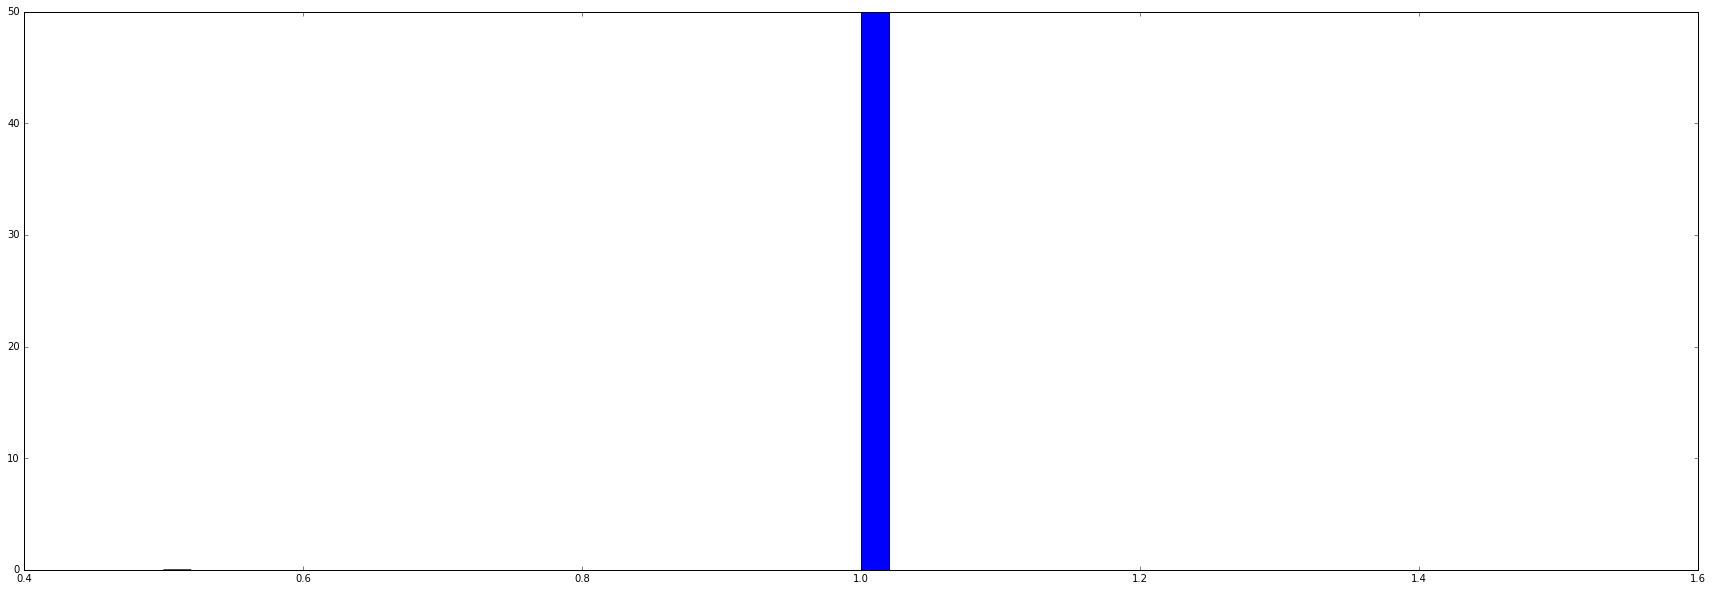

In [19]:
distrib_peak_len(outfile)

**No problem with this dataset, I kept the gene loci name for future comparison after reannotation with GENCODE**

---
### m5C_Hussain_hg38

In [20]:
infile = "./PTM_Original_Datasets/m5C_Hussain_hg38.bed"
PMID = "23871666"
cell = "HEK293"
modification = "m5C"
method = "miCLIP"
author = "Hussain"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/m5C_Hussain_hg38.bed
Total lines:	1090

0	# Transcriptome-wide map of m5C [hg38 coordinates]
1	# Reference: Hussain et al., Genome Biology 14, 215 (2013) [PMID 24286375, DOI 10.1186/gb4143]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	16535295	16535296	Hussain|id102	0	-
7	chr1	16535303	16535304	Hussain|id103	0	-
8	chr1	16535309	16535310	Hussain|id104	0	-
9	chr1	16545955	16545956	Hussain|id105	0	-

1085	chrX	56600603	56600604	Hussain|id1081	0	-
1086	chrX	91280207	91280208	Hussain|id1082	0	+
1087	chrX	121653629	121653630	Hussain|id1075	0	-
1088	chrY	11204085	11204086	Hussain|id1083	0	-
1089	chrY	13552443	13552444	Hussain|id1084	0	-

|0|chr6|chr1|chr5|chr17|chr14|chr16|chr11|chr2|chr8|chr15|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|368|92|88|87|73|59|44|41|39|28|...|

|1|13552443|11204085|121653629|91280207|56600

In [9]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|-\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

1084 Lines processed	1084 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Hussain_m5C_HEK293_hg38_cleaned.bed
Total lines:	1090

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:22:11.200389
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m5C|Cell_type=HEK293|Analysis_method=miCLIP|Pubmed_ID=23871666
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	16535295	16535296	m5C|HEK293|miCLIP|23871666|-	0	-
7	chr1	16535303	16535304	m5C|HEK293|miCLIP|23871666|-	0	-
8	chr1	16535309	16535310	m5C|HEK293|miCLIP|23871666|-	0	-
9	chr1	16545955	16545956	m5C|HEK293|miCLIP|23871666|-	0	-

1085	chrX	56600603	56600604	m5C|HEK293|miCLIP|23871666|-	0	-
1086	chrX	91280207	91280208	m5C|HEK293|miCLIP|23871666|-	0	+
1087	chrX	121653629	121653630	m5C|HEK293|miCLIP|23871666|-	0	-
1088	chrY	11204085	11204086	m5C|HEK293|miCL

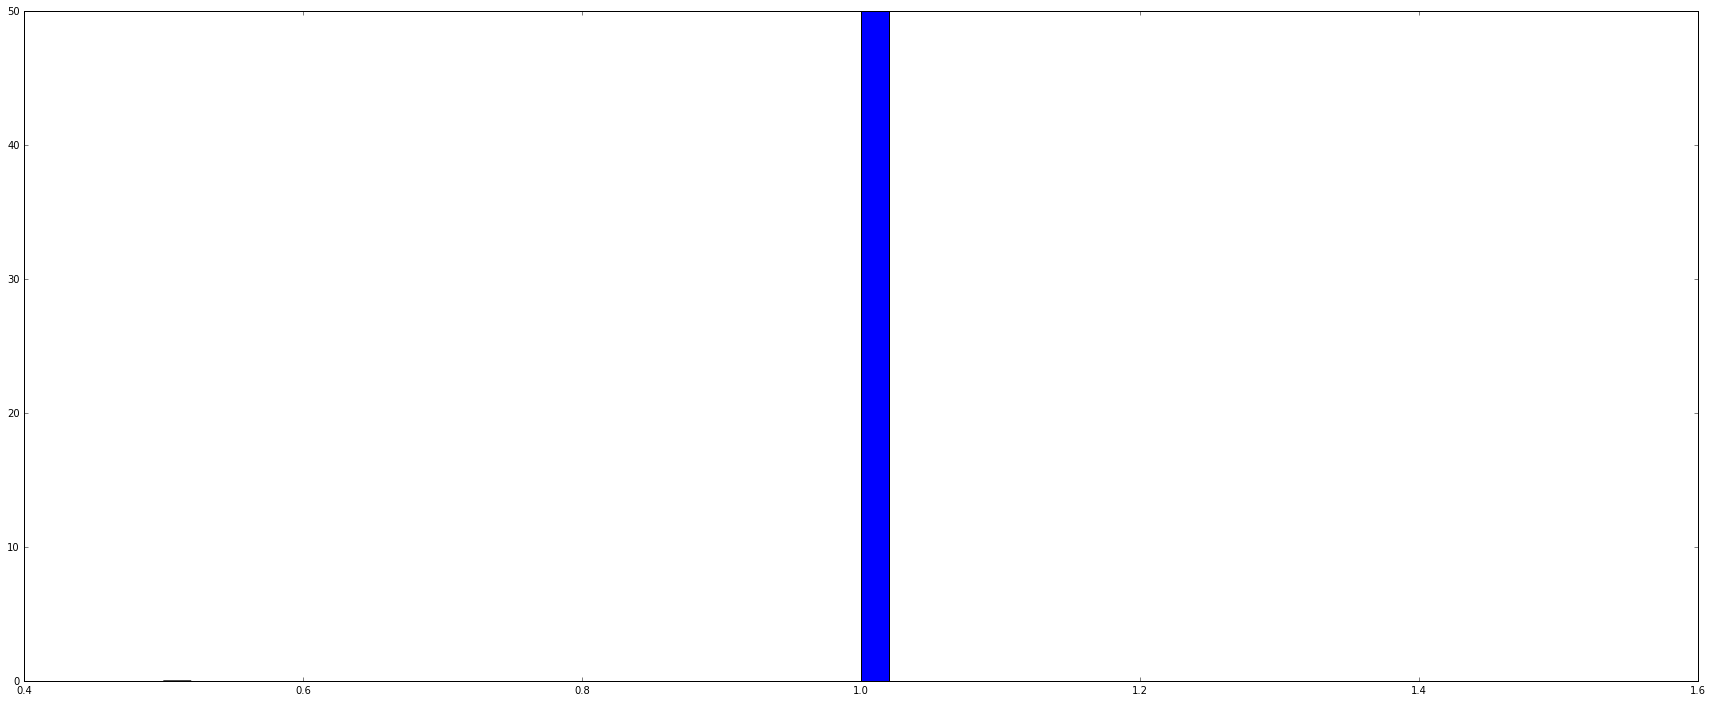

In [13]:
distrib_peak_len(outfile)

**No problem with this dataset, Since there is no gene loci, I just filed the field with a dash to indicate that it is empty**

### m5C_Khoddami_hg38

In [21]:
infile="./PTM_Original_Datasets/m5C_Khoddami_hg38.bed"
PMID = "23604283"
cell = "MEF"
modification = "m5C"
method = "AzaIP"
author = "Khoddami"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/m5C_Khoddami_hg38.bed
Total lines:	20559

0	# Transcriptome-wide map of m5C [hg38 coordinates]
1	# Reference: Khoddami and Cairns, Nat. Biotechnol. 31, 458 (2013) [PMID 23604283, DOI 10.1038/nbt.2566]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	16545917	16545918	Khoddami|tRNA-Gly-GGG	0	-
7	chr1	16545919	16545920	Khoddami|tRNA-Gly-GGG	0	-
8	chr1	16545920	16545921	Khoddami|tRNA-Gly-GGG	0	-
9	chr1	16545921	16545922	Khoddami|tRNA-Gly-GGG	0	-

20554	chrY	3367777	3367778	Khoddami|tRNA-Glu-GAG	0	+
20555	chrY	3367784	3367785	Khoddami|tRNA-Glu-GAG	0	+
20556	chrY	3367799	3367800	Khoddami|tRNA-Glu-GAG	0	+
20557	chrY	3367804	3367805	Khoddami|tRNA-Glu-GAG	0	+
20558	chrY	3367808	3367809	Khoddami|tRNA-Glu-GAG	0	+

|0|chr15|chr6|chr1|chr17|chr16|chr14|chr5|chr12|chr7|chr3|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|5959|3648|1

In [11]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

20553 Lines processed	20553 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Khoddami_m5C_MEF_hg38_cleaned.bed
Total lines:	20559

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:22:52.164144
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m5C|Cell_type=MEF|Analysis_method=AzaIP|Pubmed_ID=23604283
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	16545917	16545918	m5C|MEF|AzaIP|23604283|tRNA-Gly-GGG	0	-
7	chr1	16545919	16545920	m5C|MEF|AzaIP|23604283|tRNA-Gly-GGG	0	-
8	chr1	16545920	16545921	m5C|MEF|AzaIP|23604283|tRNA-Gly-GGG	0	-
9	chr1	16545921	16545922	m5C|MEF|AzaIP|23604283|tRNA-Gly-GGG	0	-

20554	chrY	3367777	3367778	m5C|MEF|AzaIP|23604283|tRNA-Glu-GAG	0	+
20555	chrY	3367784	3367785	m5C|MEF|AzaIP|23604283|tRNA-Glu-GAG	0	+
20556	chrY	3367799	3367800	m5C|MEF|AzaIP|23604283|tRNA-Glu-GAG	0	+
20

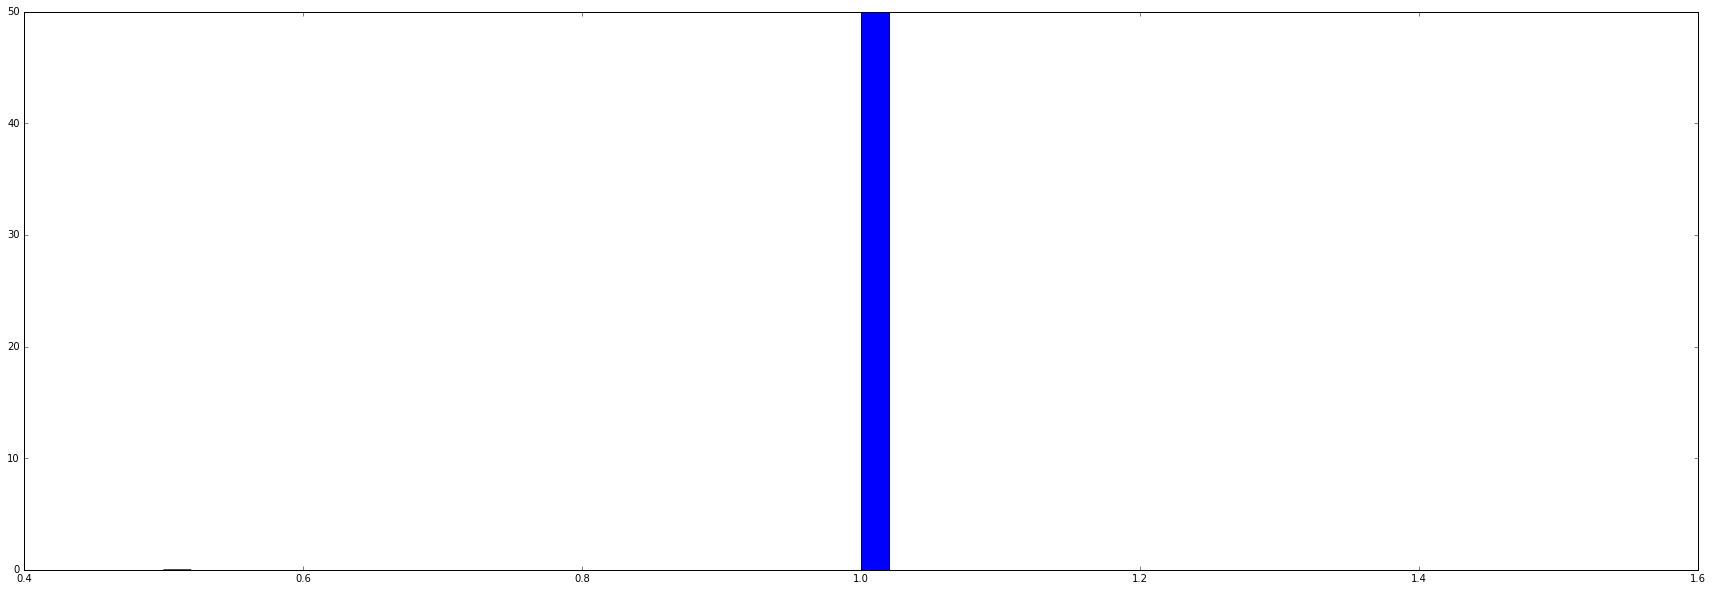

In [22]:
distrib_peak_len(outfile)

**No problem with this dataset. It seems to be focussed on tRNA gene that are clearly over-represented in the gene list**

---
### m5C_Squires_hg38

In [23]:
infile="./PTM_Original_Datasets/m5C_Squires_hg38.bed"
PMID = "22344696"
cell = "HeLa"
modification = "m5C"
method = "bisulfite_seq"
author = "Squires"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/m5C_Squires_hg38.bed
Total lines:	10496

0	# Transcriptome-wide map of m5C [hg38 coordinates]
1	# Reference: Squires et al., Nucleic Acids Res. 40, 5023 (2012) [PMID 22344696, DOI 10.1093/nar/gks144]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	631539	631540	Squires|id1	0	+
7	chr1	631540	631541	Squires|id2	0	+
8	chr1	632285	632286	Squires|id3	0	+
9	chr1	632286	632287	Squires|id4	0	+

10491	chrX	155291091	155291092	Squires|id10271	0	-
10492	chrX	156023069	156023070	Squires|id10272	0	+
10493	chrY	5105140	5105141	Squires|id10273	0	+
10494	chrY	5338229	5338230	Squires|id10274	0	-
10495	chrY	10192049	10192050	Squires|id10275	0	-

|0|chr1|chr17|chr19|chr11|chr3|chr6|chr2|chr5|chr12|chr7|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|1169|734|660|659|621|608|582|576|497|472|...|

|1|1629420|1629419|10192049|5338229|510514

In [13]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|-\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

10490 Lines processed	10490 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Squires_m5C_HeLa_hg38_cleaned.bed
Total lines:	10496

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:23:48.676446
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m5C|Cell_type=HeLa|Analysis_method=bisulfite_seq|Pubmed_ID=22344696
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	631539	631540	m5C|HeLa|bisulfite_seq|22344696|-	0	+
7	chr1	631540	631541	m5C|HeLa|bisulfite_seq|22344696|-	0	+
8	chr1	632285	632286	m5C|HeLa|bisulfite_seq|22344696|-	0	+
9	chr1	632286	632287	m5C|HeLa|bisulfite_seq|22344696|-	0	+

10491	chrX	155291091	155291092	m5C|HeLa|bisulfite_seq|22344696|-	0	-
10492	chrX	156023069	156023070	m5C|HeLa|bisulfite_seq|22344696|-	0	+
10493	chrY	5105140	5105141	m5C|HeLa|bisulfite_seq|22344696|-	0	+
10494	chrY	5338

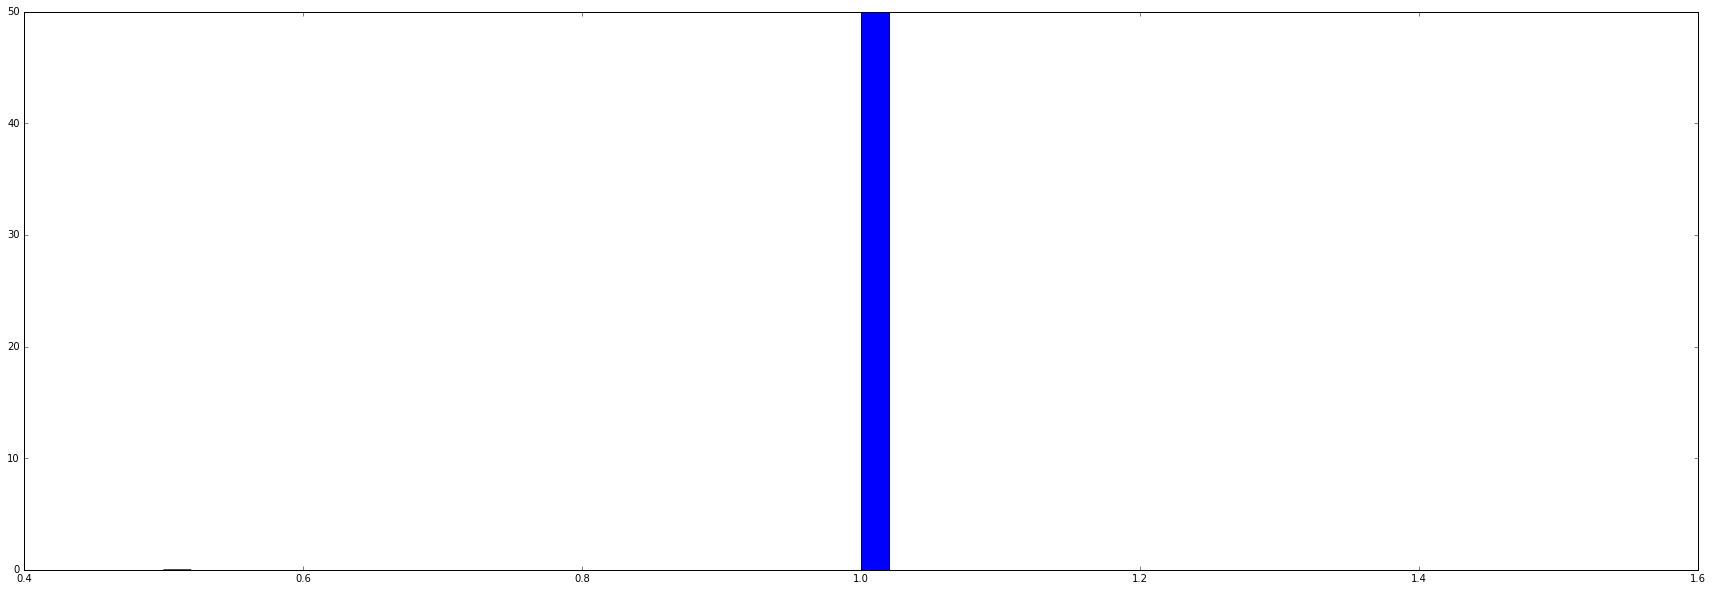

In [24]:
distrib_peak_len(outfile)

**1 nt wide peaks = No problem with this dataset. Since there are no gene loci, I just filed the field with a dash to indicate that it is empty**

---
### m6A_Dominissini_hg38

In [51]:
infile="./PTM_Original_Datasets/m6A_Dominissini_hg38.bed"
PMID = "22575960"
cell = "HepG2"
modification = "m6A"
method = "M6A_seq"
author = "Dominissini"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/m6A_Dominissini_hg38.bed
Total lines:	25782

0	# Transcriptome-wide map of m6A [hg38 coordinates]
1	# Reference: Dominissini et al., Nature 485, 201 (2012) [PMID 22575960, DOI 10.1038/nature11112]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	10000	10156	Dominissini|NR_003285|NR_003285	0	+
7	chr1	10000	12006	Dominissini|NR_003286|NR_003286	0	+
8	chr1	10000	15207	Dominissini|NR_003287|NR_003287	0	+
9	chr1	14405	29358	Dominissini|FLJ00038|iduc009viw.1	0	-

25777	chrY	25975511	25988101	Dominissini|PRY|iduc004fxh.1	0	+
25778	chrY	56954307	56968975	Dominissini|SPRY3|iduc004fxi.1	0	+
25779	chrY	57067874	57130276	Dominissini|VAMP7|iduc004fxj.1	0	+
25780	chrY	57184099	57197337	Dominissini|IL9R|iduc004fxn.1	0	+
25781	chrY	57208832	57212183	Dominissini|WASH1|iduc010nxs.1	0	+

|0|chr1|chr19|chr2|chr11|chr17|chr6|chr15|chr3|chr7|chr12|...|
|:---|:---|:--

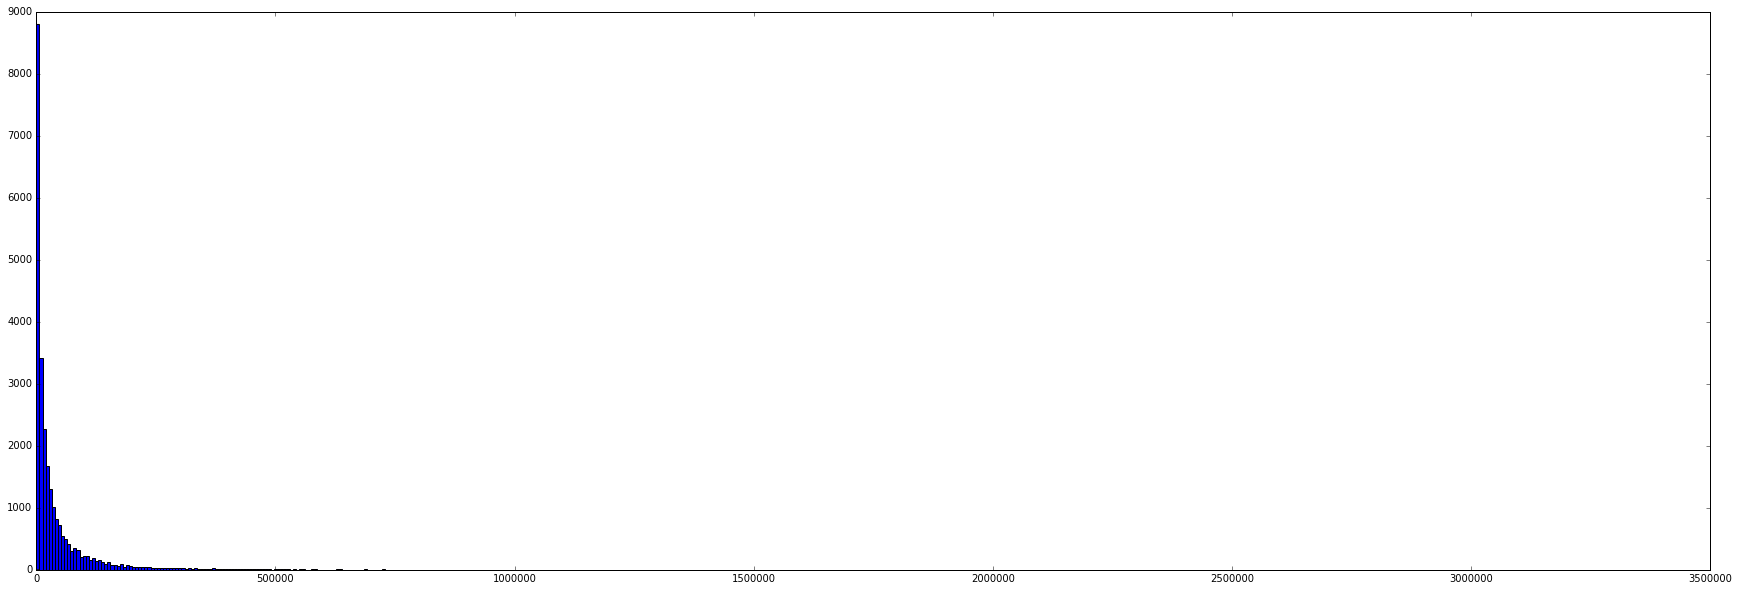

In [4]:
distrib_peak_len(infile, normed=False, bins=500)

**Apparently there is a problem in the data since some of the peaks can be up to 3 500 000 with is much longer than initially described in the paper. I dowloaded the original peak calling file from the sup data of the paper to compare with this datafile.**

In [30]:
infile="./PTM_Original_Datasets/m6A_Dominissini_hg19_original_table.csv"
file_summary(infile)

Filename:	./PTM_Original_Datasets/m6A_Dominissini_hg19_original_table.csv
Total lines:	25919

0	#chr	txStart	txEnd	strand	geneSymbol
1	chr1	24475	25940	-	F379
2	chr1	58953	59871	+	OR4F5
3	chr1	127586	128558	-	DQ580039
4	chr1	129367	129428	-	DQ600587
5	chr1	310946	310977	+	DQ599874
6	chr1	311008	311086	+	DQ599768
7	chr1	314322	314353	+	DQ574670
8	chr1	314353	314385	+	DQ596298
9	chr1	314432	314501	+	DQ599768

25914	chrY	22700500	22702366	+	TTY6
25915	chrY	57764372	57767722	+	WASH1
25916	chr1	1	156	+	NR_003285
25917	chr1	1	1869	+	NR_003286
25918	chr1	1	5070	+	NR_003287

|0|chr1|chr19|chr2|chr11|chr17|chr6|chr15|chr7|chr3|chr12|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|2501|1668|1576|1566|1480|1370|1362|1326|1312|1233|...|

|1|1|46717826|3447992|73075997|72861477|95740887|22995127|22864393|2680336|153943093|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|3|2|2|2|2|2|2|2|2|2|...|

|2|2429015|101096493|92494109|107825998|47848011|3577

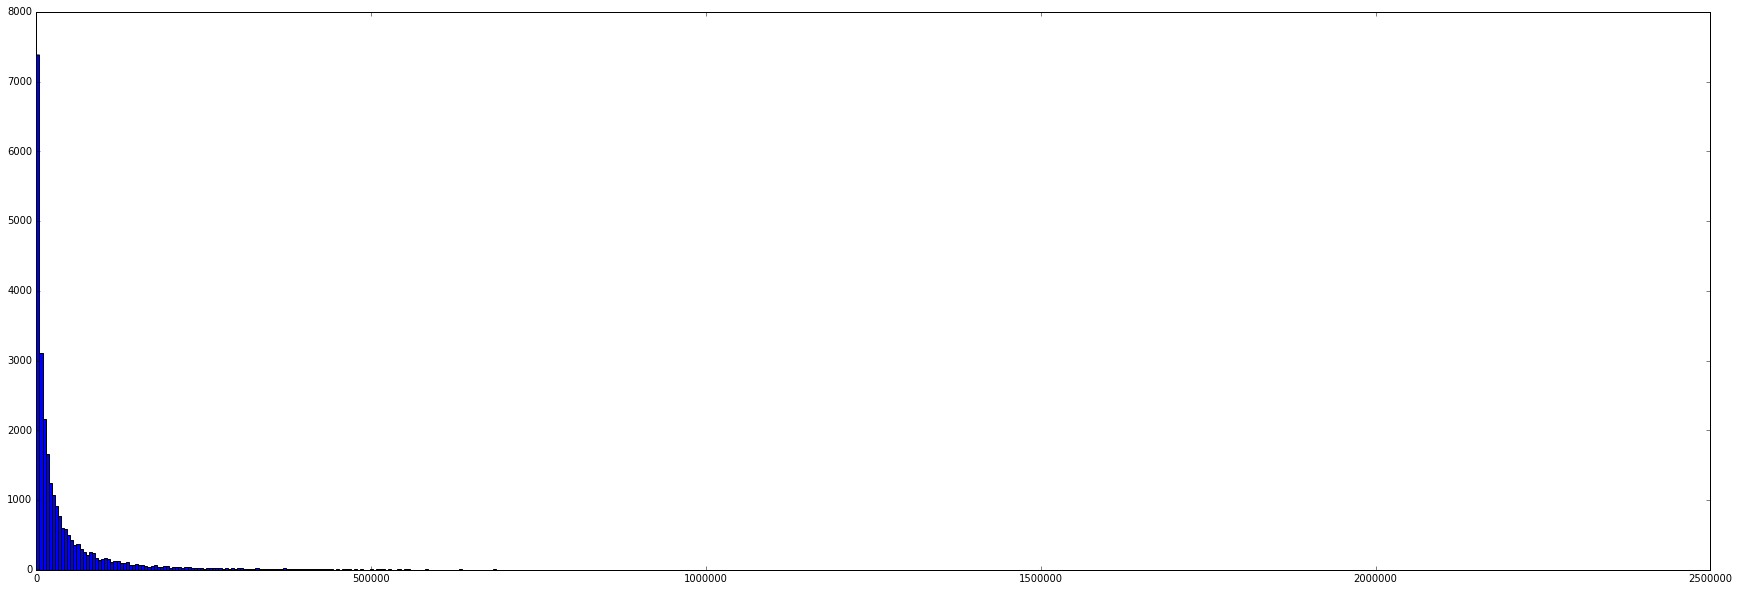

In [26]:
distrib_peak_len(infile, normed=False, bins=500)

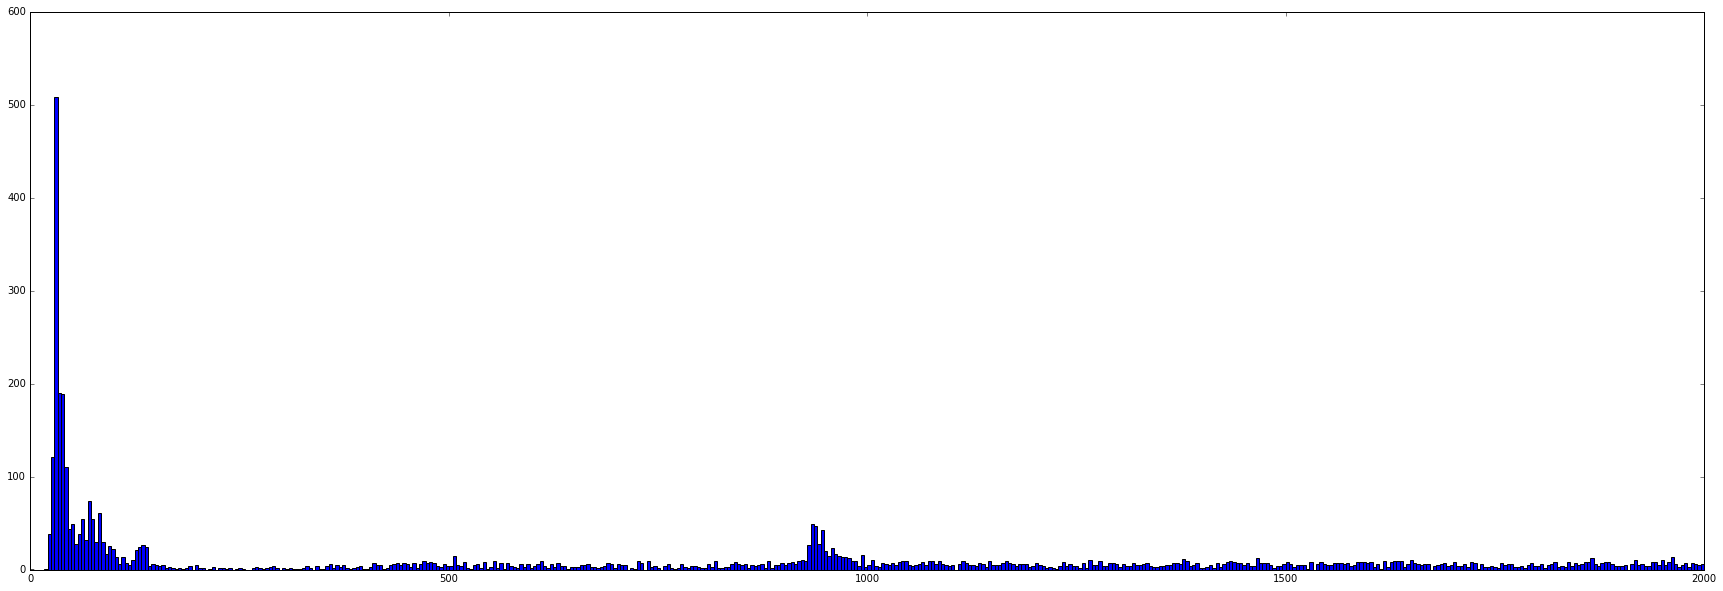

In [27]:
distrib_peak_len(infile, normed=False, range=[1,2000], bins=500)

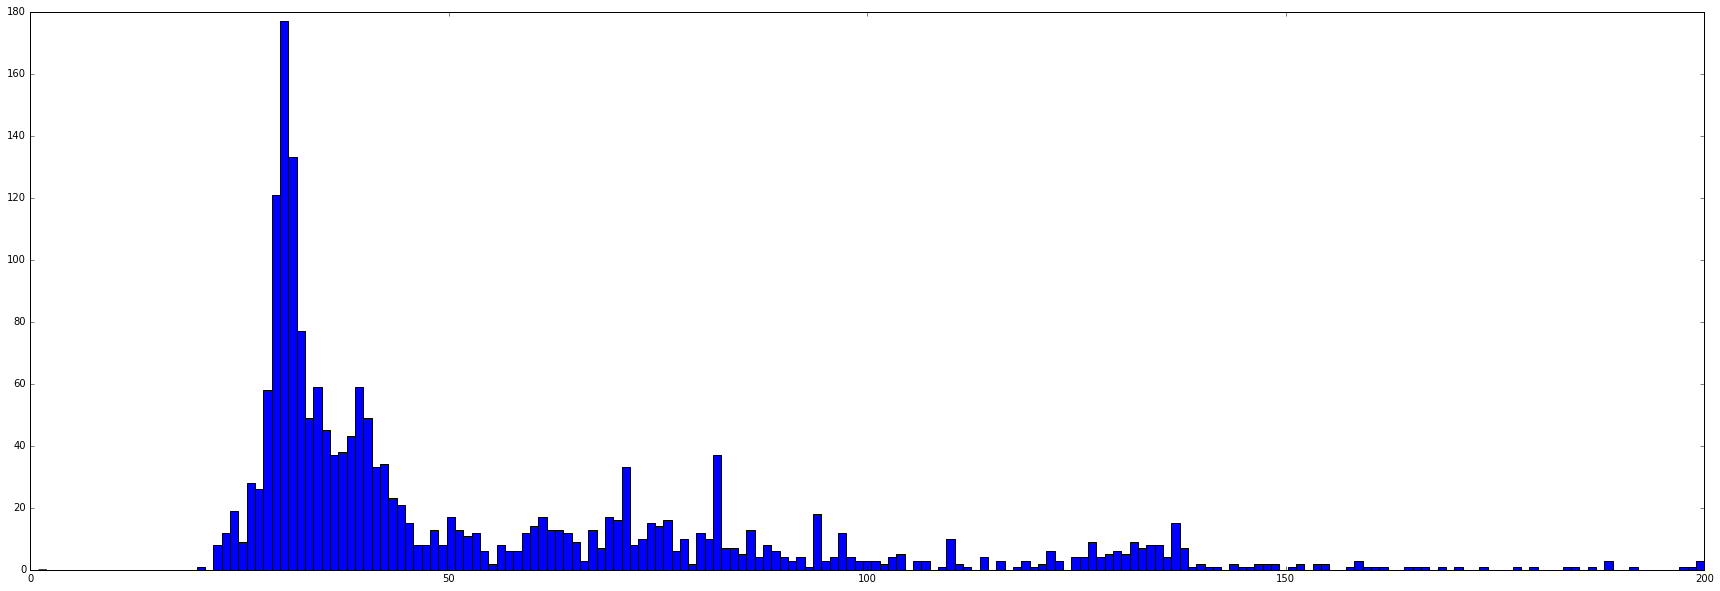

In [28]:
distrib_peak_len(infile, normed=False, range=[1,200], bins=200)

**The same problem is also found in the original data, though the values only goes up to 2 500 000... I think that long peaks were improperly called... Looking at the data in detail we can see that most of the peaks are found in the 1 to 130 range. There is also a second smaller peak around 1000. Looking at the original article the mapping was done on the human transcriptome and not the genome. Apparently the coordinates were converted to the genome after and that might explain this decrepancy. I have 2 options => Starting from scratch with a recent genome build, but the dataset seems quite tricky and I am not sure I could do it as well as the original authors. The second option is to be retrictive and keep only the small peaks ie > 1000 pb. I think that I will start by this alternative and go back to the data again if needed. To be sure of the quality of the data I will start from the original data and do the liftover conversion myself.**

In [52]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"
infile="./PTM_Original_Datasets/m6A_Dominissini_hg19_original_table.csv"
outfile = "./PTM_Clean_Datasets/Dominissini_m6A_HepG2_hg19_cleaned.bed"

init_template=[0,"\t",1,"\t",2,"\t",3,"\t",4]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t-\t",3]

# Predicate function to filter out large peaks 
predicate = lambda val_list: abs(int(val_list[1])-int(val_list[2])) <= 1000

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-",
    predicate = predicate)

file_summary(outfile)

25918 Lines processed	2994 Lines pass	22924 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Datasets/Dominissini_m6A_HepG2_hg19_cleaned.bed
Total lines:	3000

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-13 14:24:15.657786
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m6A|Cell_type=HepG2|Analysis_method=M6A_seq|Pubmed_ID=22575960
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	58953	59871	m6A|HepG2|M6A_seq|22575960|OR4F5	-	+
7	chr1	127586	128558	m6A|HepG2|M6A_seq|22575960|DQ580039	-	-
8	chr1	129367	129428	m6A|HepG2|M6A_seq|22575960|DQ600587	-	-
9	chr1	310946	310977	m6A|HepG2|M6A_seq|22575960|DQ599874	-	+

2995	chrX	76056091	76056179	m6A|HepG2|M6A_seq|22575960|DJ442759	-	-
2996	chrX	95478740	95479557	m6A|HepG2|M6A_seq|22575960|LOC643486	-	-
2997	chrX	109354872	109354944	m6A|HepG2|M6A_seq|22575960|SNORD96B	-	-
2998	

**The filtering based on the peak length size remove a lot of peaks = nearly 90 % of the dataset**

In [53]:
# Conversion to hg38 with Crossmap/liftover
lifover_chainfile = "../LiftOver_chain_files/hg19ToHg38.over.chain.gz"
input_bed = "./PTM_Clean_Datasets/Dominissini_m6A_HepG2_hg19_cleaned.bed"
temp_bed = "./PTM_Clean_Datasets/Dominissini_m6A_HepG2_hg38_temp.bed"

cmd = "CrossMap.py bed {} {} {}".format(lifover_chainfile, input_bed, temp_bed)  
bash(cmd)

# Rewriting and updating of the header removed by Crossmap
final_bed = "./PTM_Clean_Datasets/Dominissini_m6A_HepG2_hg38_cleaned.bed"
header = generate_header(PMID, cell, modification, method)

with open (temp_bed, "r") as infile, open (final_bed, "w") as outfile:
    outfile.write (header)
    for line in infile:
        outfile.write (line)

file_summary(final_bed)


@ 2016-06-13 14:24:41: Read chain_file:  ../LiftOver_chain_files/hg19ToHg38.over.chain.gz

Filename:	./PTM_Clean_Datasets/Dominissini_m6A_HepG2_hg38_cleaned.bed
Total lines:	2900

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-13 14:24:42.098489
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m6A|Cell_type=HepG2|Analysis_method=M6A_seq|Pubmed_ID=22575960
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	58953	59871	m6A|HepG2|M6A_seq|22575960|OR4F5	+	+
7	chr1	127586	128558	m6A|HepG2|M6A_seq|22575960|DQ580039	-	-
8	chr1	129367	129428	m6A|HepG2|M6A_seq|22575960|DQ600587	-	-
9	chr1	501020	501617	m6A|HepG2|M6A_seq|22575960|DQ574721	-	-

2895	chrX	56753512	56754309	m6A|HepG2|M6A_seq|22575960|LOC442454	-	-
2896	chrX	76835666	76835754	m6A|HepG2|M6A_seq|22575960|DJ442759	-	-
2897	chrX	96223741	96224558	m6A|HepG2|M6A_seq|22575960|LOC64

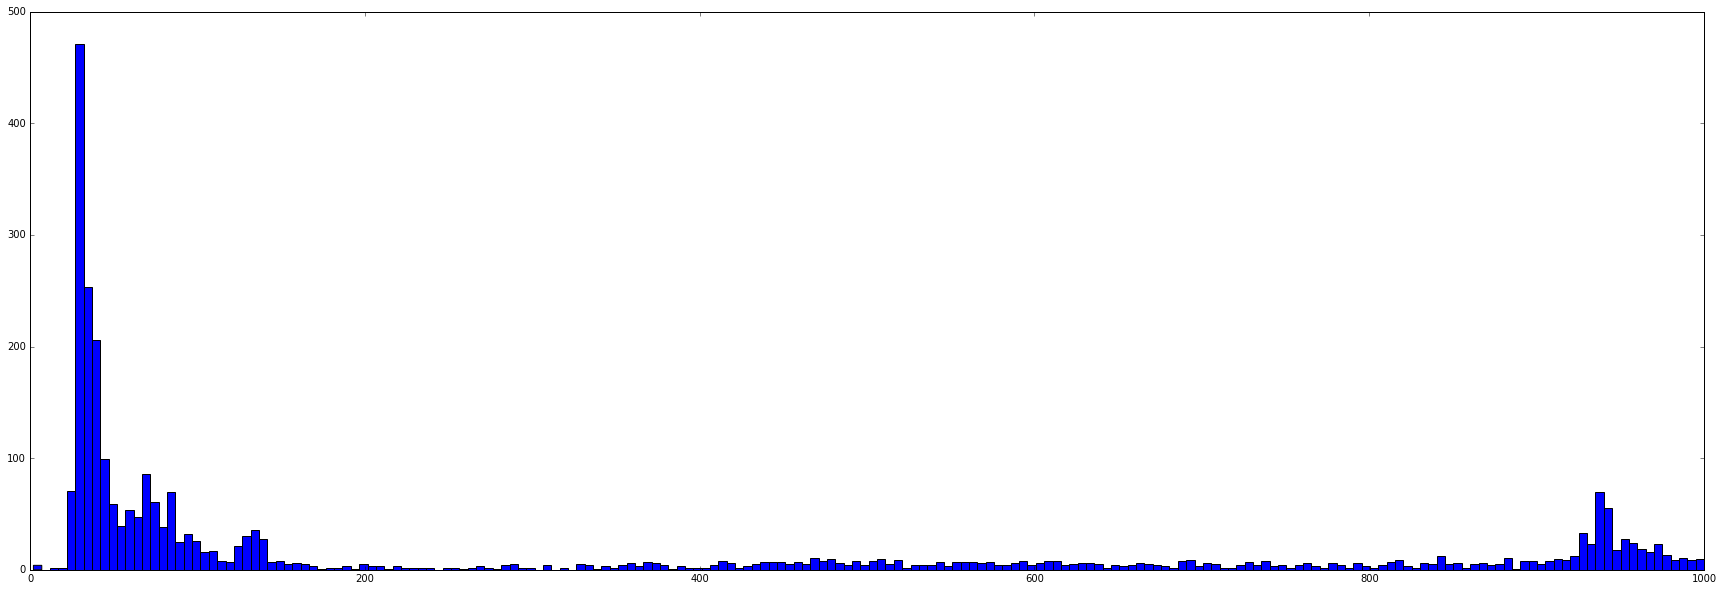

In [55]:
distrib_peak_len(final_bed, normed=False, bins=200)

**It is much better but I only have 2894 sites out of the 25000 initially in the dataset. For this first exploratory study it should be OK, but I will probably have to go back to the original data again later**

---
### m6A_Meyer_hg38

In [14]:
infile="./PTM_Original_Datasets/m6A_Meyer_hg38.bed"
PMID = "22608085"
cell = "HEK293"
modification = "m6A"
method = "MeRIP_Seq"
author = "Meyer"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/m6A_Meyer_hg38.bed
Total lines:	4347

0	# Transcriptome-wide map of m6A [hg38 coordinates]
1	# Reference: Meyer et al., Cell 149, 1635 (2012) [PMID 22608085, DOI 10.1016/j.cell.2012.05.003]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	1055019	1055133	Meyer|AGRN|3'UTR	0	+
7	chr1	1055132	1055245	Meyer|AGRN|3'UTR	0	+
8	chr1	1055419	1055620	Meyer|AGRN|3'UTR	0	+
9	chr1	1232619	1232795	Meyer|B3GALT6|CDS	0	+

4342	chrX	154488410	154488595	Meyer|SLC10A3|CDS	0	-
4343	chrX	154488594	154488779	Meyer|SLC10A3|CDS	0	-
4344	chrX	154488778	154488961	Meyer|SLC10A3|Exon	0	-
4345	chrX	155216447	155216548	Meyer|VBP1|Exon	0	+
4346	chrX	155260564	155260740	Meyer|RAB39B|3'UTR	0	-

|0|chr1|chr3|chr2|chr16|chr6|chrX|chr17|chr5|chr8|chr12|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|364|269|262|240|233|232|229|221|208|199|...|

|1|1552605

In [16]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"\t",6,"\t",7]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",6,"\t",7]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

4341 Lines processed	4341 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Datasets/Meyer_m6A_HEK293_hg38_cleaned.bed
Total lines:	4347

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-13 12:23:21.117650
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m6A|Cell_type=HEK293|Analysis_method=MeRIP_Seq|Pubmed_ID=22608085
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	1055019	1055133	m6A|HEK293|MeRIP_Seq|22608085|AGRN	0	+
7	chr1	1055132	1055245	m6A|HEK293|MeRIP_Seq|22608085|AGRN	0	+
8	chr1	1055419	1055620	m6A|HEK293|MeRIP_Seq|22608085|AGRN	0	+
9	chr1	1232619	1232795	m6A|HEK293|MeRIP_Seq|22608085|B3GALT6	0	+

4342	chrX	154488410	154488595	m6A|HEK293|MeRIP_Seq|22608085|SLC10A3	0	-
4343	chrX	154488594	154488779	m6A|HEK293|MeRIP_Seq|22608085|SLC10A3	0	-
4344	chrX	154488778	154488961	m6A|HEK293|MeRIP_Seq|22608085|SLC

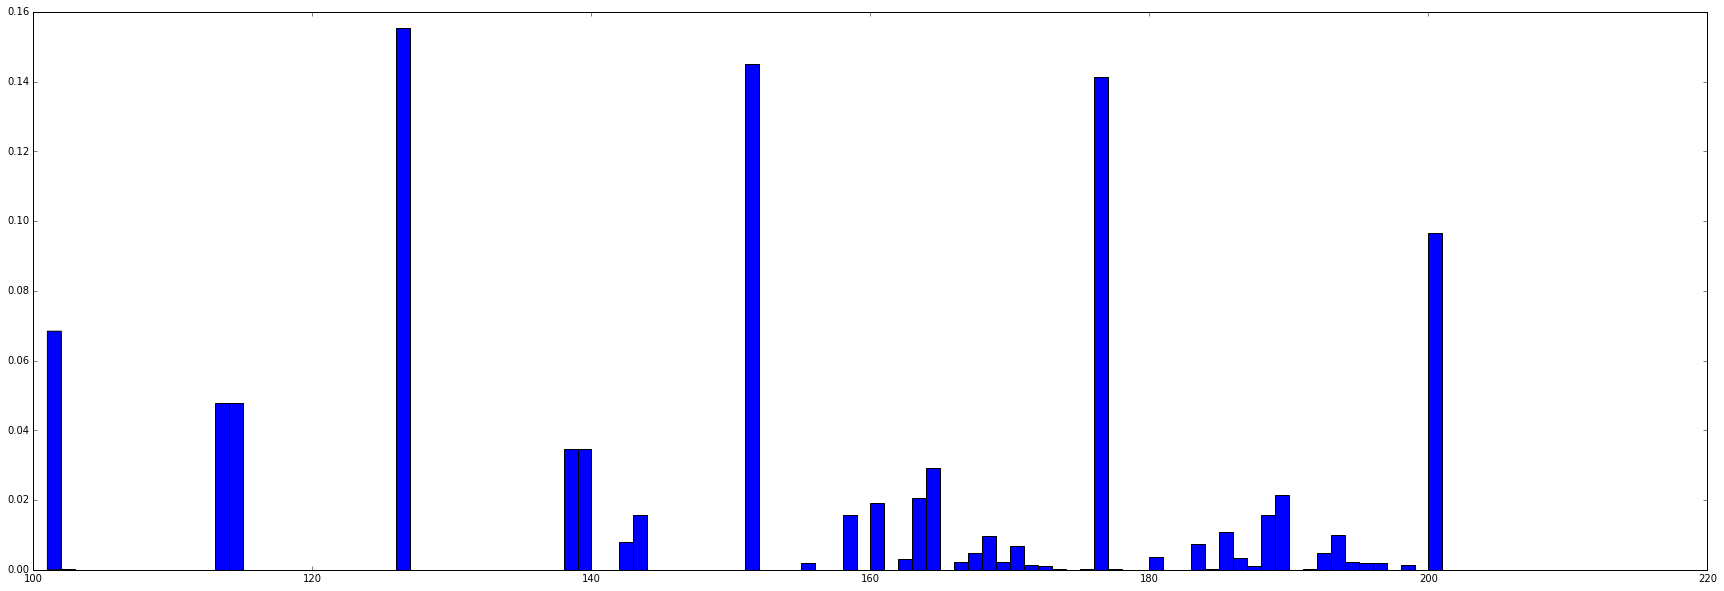

In [17]:
distrib_peak_len(outfile, bins = 100)

**The original dataset was OK and clean. Contrary to the previous dataset the width of the peaks are between 100 and 220 pb wich is clearly better. It is however interesting to notice that the peak lengths are not randomly distributed** 

---
### miCLIP_m6A_Linder2015_hg38

In [27]:
infile="./PTM_Original_Datasets/miCLIP_m6A_Linder2015_hg38.bed"
PMID = "26121403"
cell = "HEK293"
modification = "m6A:m6Am"
method = "miCLIP"
author = "Linder"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/miCLIP_m6A_Linder2015_hg38.bed
Total lines:	15174

0	# miCLIP-based transcriptome-wide map of m6A and m6Am sites [hg38 coordinates]
1	# Reference: Linder et al., Nat. Methods 12, 767 (2015) [PMID 26121403, DOI 10.1038/nmeth.3453]
2	# Data converted to BED from Supplementary tables S2 and S3, conversion to hg38 using liftOver.
3	#
4	# Data is part of the R package RNAModR
5	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
6	#
7	chr1	631479	631480	B045_1-4_chr1_f_c1[k=4][m=2]_CTACT;MIR6723;hsa-mir-6723;microRNAmir-6723	1	+
8	chr1	634538	634539	B045_1-4_chr1_f_c5[k=52][m=2]_ATACC;MIR6723;hsa-mir-6723;microRNAmir-6723	1	+
9	chr1	931395	931396	B045_1-4_chr1_f_c7[k=4][m=2]_AGACT;XM_005244723;ENSG00000187634;SAMD11	1	+

15169	chrX	154516231	154516232	105216[gene=chrX_r_c40520][PH=3][PH0=0.06][P=1.02e-02]_CCATT;XM_005274713;ENSG00000071889;FAM3A	1	-
15170	chrX	155071078	155071079	105658[gene=chrX_r_c40716][PH=3][PH0=0.12][P=2.81e-02]_CCATT;NM_001018024;E

In [22]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"\t",4,"\t",5]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|-\t",4,"\t",5]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

15167 Lines processed	15167 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Linder_m6A:m6Am_HEK293_hg38_cleaned.bed
Total lines:	15173

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 12:27:58.239000
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m6A:m6Am|Cell_type=HEK293|Analysis_method=miCLIP|Pubmed_ID=26121403
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	631479	631480	m6A:m6Am|HEK293|miCLIP|26121403|-	1	+
7	chr1	634538	634539	m6A:m6Am|HEK293|miCLIP|26121403|-	1	+
8	chr1	931395	931396	m6A:m6Am|HEK293|miCLIP|26121403|-	1	+
9	chr1	942770	942771	m6A:m6Am|HEK293|miCLIP|26121403|-	2	+

15168	chrX	154516231	154516232	m6A:m6Am|HEK293|miCLIP|26121403|-	1	-
15169	chrX	155071078	155071079	m6A:m6Am|HEK293|miCLIP|26121403|-	1	-
15170	chrY	10195941	10195942	m6A:m6Am|HEK293|miCLIP|26121403|-	1	+
15171	c

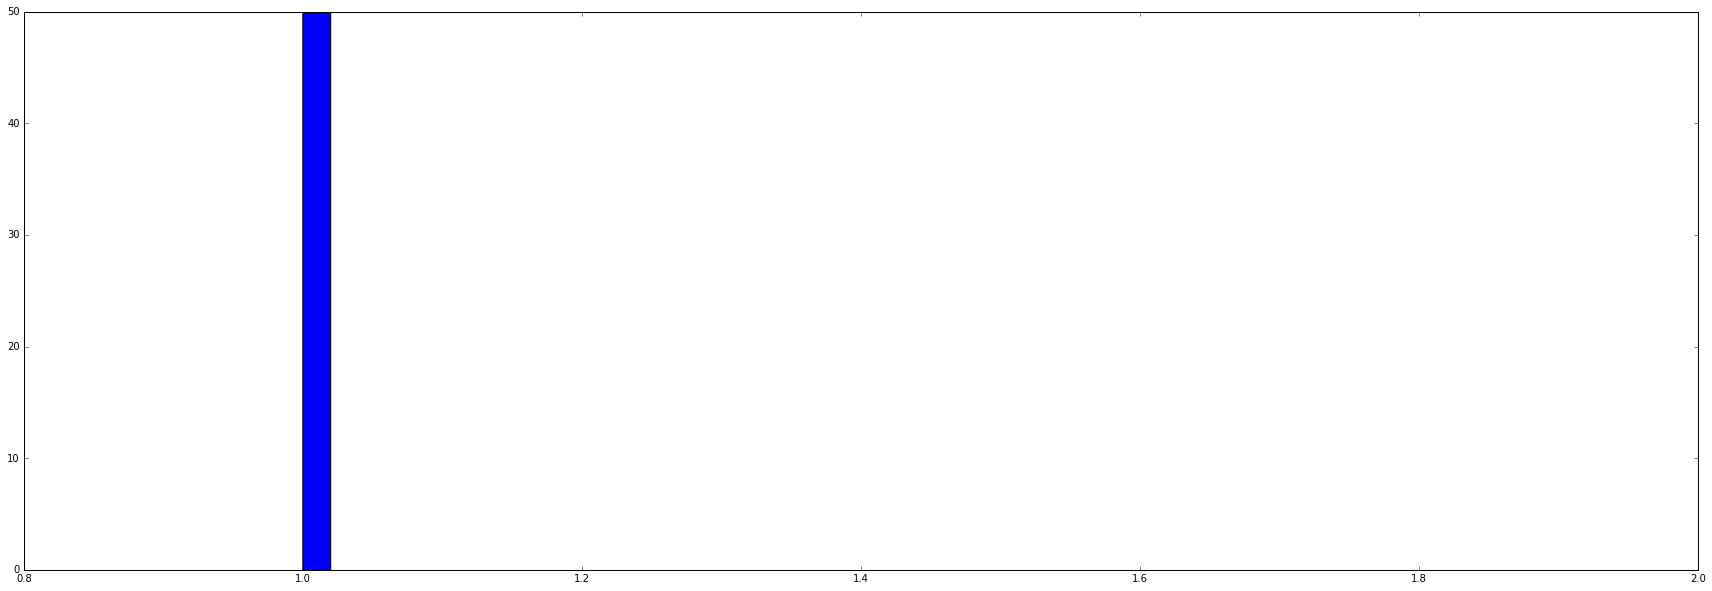

In [28]:
distrib_peak_len(outfile)

**The name field is unusable since it contains a random number of fieds... I cannot parse it easily. That is not a big problem since I will reannotate the data based on the last gencode annotation realease, I did not save any of the informations contained in the original name field. With miCLIP data the peak are 1 nt wide**

---
### MeRIPseq_m1A_Dominissini2016_hg38

In [29]:
infile="./PTM_Original_Datasets/MeRIPseq_m1A_Dominissini2016_hg38.bed"
PMID = "26863196"
cell = "HeLa:HEK293:HepG2"
modification = "m1A"
method = "M1A_seq"
author = "Dominissini"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/MeRIPseq_m1A_Dominissini2016_hg38.bed
Total lines:	32136

0	# MeRIP-seq-based transcriptome-wide map of m1A [hg38 coordinates]
1	# Reference: Dominissini et al., Nature 530, 441 (2016) [PMID 26863196, DOI 10.1038/nature16998]
2	# Data converted to BED from Supplementary table 1, conversion to hg38 using liftOver.
3	# Strand information is missing in original reference, and was added using current
4	# RefSeq annotation from NCBI and UCSC.
5	#
6	# Data is part of the R package RNAModR
7	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
8	#
9	chr1	17001	17002	NR_024540|ncRNA|HeLa	0	-

32131	chrX	155216522	155216523	NM_001303545|5UTR|HEPG2_common_mRNA	0	+
32132	chrX	155216526	155216527	NM_003372|CDS|HeLa	0	+
32133	chrX	155612852	155612853	NM_001184797|5UTR|HEPG2_common_mRNA	0	-
32134	chrX	155612855	155612856	NM_001184797|5UTR|HeLa	0	-
32135	chrX	155612864	155612865	NM_001184797|5UTR|HEPG2_Glucose_starv_4h	0	-

|0|chr1|chr19|chr17|chr16|chr2|chr11|chr1

**I don't know understand some of the categories for HEPG2 cells**
* Hela = No ambiguity 
* HEK293 = No ambiguity
* HEPG2_common_mRNA = Unclear, but aparently looking at the data this is the general RNA dataset (including ncRNA) after peak calling in untreated HEPG2 cells  
* HEPG2_heat_shock_4h = No ambiguity
* HEPG2_Glucose_starv_4h = No ambiguity
* HEPG2_common_total_RNA = Unclear, but it seems to be commons peaks shared by all the cell types.

In [37]:
###### chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"\t",6,"\t",7]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",5,"|",method,"|",PMID,"|",3,"\t",6,"\t",7]

# filter out all but A>G transition which are Inosine transition
filter_dict={5:["HEPG2_heat_shock_4h","HEPG2_Glucose_starv_4h","HEPG2_common_total_RNA"]}

# Reformat the field value A->G to A>I for standardization 
subst_dict={5:{"HEPG2_common_mRNA":"HepG2"}}

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-",
    subst_dict = subst_dict,
    filter_dict = filter_dict
    )

file_summary(outfile)

32127 Lines processed	19552 Lines pass	12575 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Dominissini_m1A_HeLa:HEK293:HepG2_hg38_cleaned.bed
Total lines:	19558

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 14:27:18.116524
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=m1A|Cell_type=HeLa:HEK293:HepG2|Analysis_method=M1A_seq|Pubmed_ID=26863196
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	17001	17002	m1A|HeLa|M1A_seq|26863196|NR_024540	0	-
7	chr1	24826	24827	m1A|HeLa|M1A_seq|26863196|NR_024540	0	-
8	chr1	778484	778485	m1A|HepG2|M1A_seq|26863196|NR_033908	0	-
9	chr1	826715	826716	m1A|HeLa|M1A_seq|26863196|NR_024321	0	-

19553	chrX	155071584	155071585	m1A|HEK293|M1A_seq|26863196|NM_001018055	0	+
19554	chrX	155216522	155216523	m1A|HepG2|M1A_seq|26863196|NM_001303545	0	+
19555	chrX	155216526	155216527	m1A

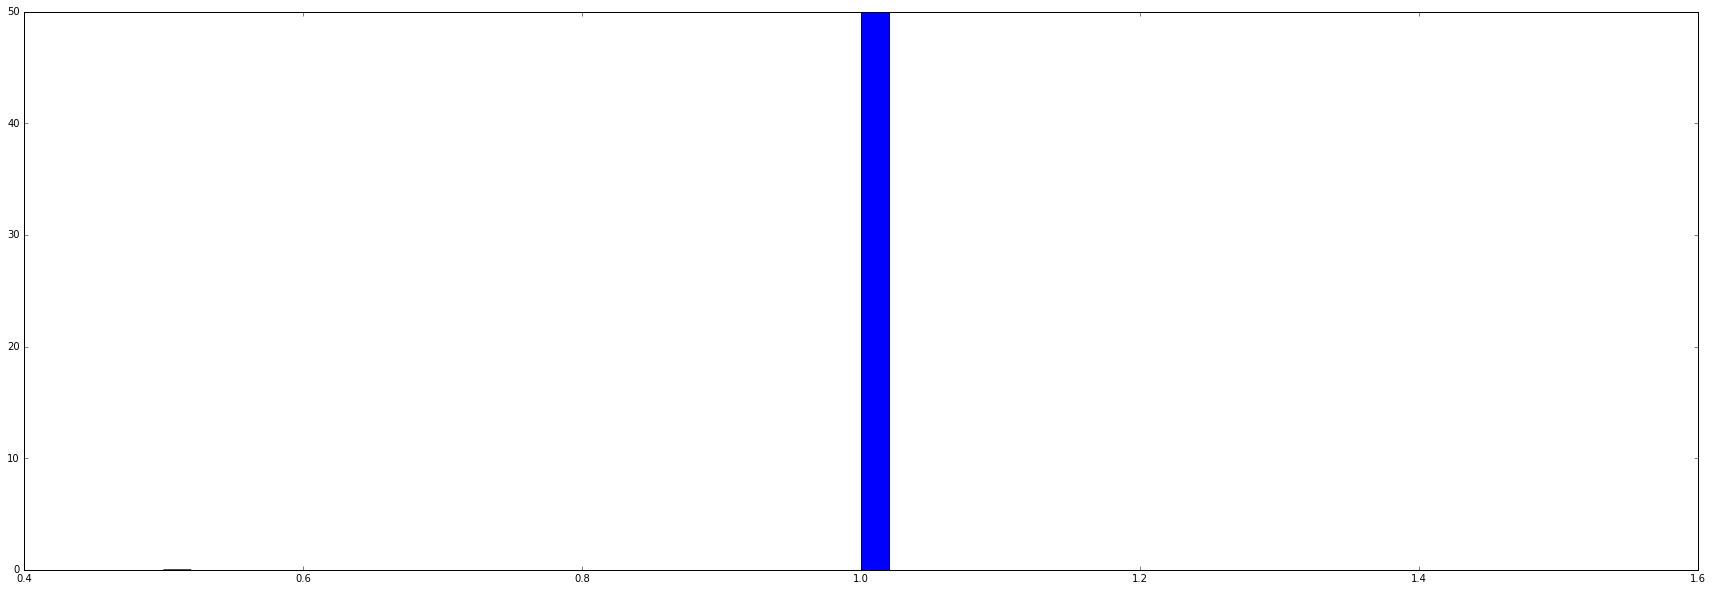

In [30]:
distrib_peak_len(outfile)

---
### pseudoU_Carlile_hg38

In [31]:
infile="./PTM_Original_Datasets/pseudoU_Carlile_hg38.bed"
PMID = "25192136"
cell = "HeLa"
modification = "Y"
method = "Pseudo_seq"
author = "Carlile"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/pseudoU_Carlile_hg38.bed
Total lines:	14

0	# Transcriptome-wide map of pseudouridine [hg38 coordinates]
1	# Reference: Carlile et al., Nature 515, 143 (2014) [PMID 25192136, DOI 10.1038/nature13802]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr11	62851987	62855914	ENST00000538654|SNHG1	1766	-
7	chr11	65497761	65506469	ENST00000534336|MALAT1	5160	+
8	chr11	65497761	65506469	ENST00000534336|MALAT1	5590	+
9	chr12	98599634	98599883	ENST00000391141|SNORA53	110	+

9	chr12	98599634	98599883	ENST00000391141|SNORA53	110	+
10	chr17	16438821	16478678	ENST00000497774|FAM211A-AS1	1537	+
11	chr2	231455799	231455936	ENST00000384158|SNROA75	84	-
12	chr6	52995619	52995950	ENST00000365328|RN7SK	250	+
13	chrX	119787352	119787484	ENST00000383895|SNORA69	81	-

|0|chr11|chrX|chr6|chr2|chr17|chr12|
|:---|:---|:---|:---|:---|:---|:---|
|Count|3|1|1|1|1|1|

|1|654977

In [32]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

8 Lines processed	8 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Carlile_Y_HeLa_hg38_cleaned.bed
Total lines:	14

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 14:23:30.530422
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=Y|Cell_type=HeLa|Analysis_method=Pseudo_seq|Pubmed_ID=25192136
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr11	62851987	62855914	Y|HeLa|Pseudo_seq|25192136|SNHG1	1766	-
7	chr11	65497761	65506469	Y|HeLa|Pseudo_seq|25192136|MALAT1	5160	+
8	chr11	65497761	65506469	Y|HeLa|Pseudo_seq|25192136|MALAT1	5590	+
9	chr12	98599634	98599883	Y|HeLa|Pseudo_seq|25192136|SNORA53	110	+

9	chr12	98599634	98599883	Y|HeLa|Pseudo_seq|25192136|SNORA53	110	+
10	chr17	16438821	16478678	Y|HeLa|Pseudo_seq|25192136|FAM211A-AS1	1537	+
11	chr2	231455799	231455936	Y|HeLa|Pseudo_seq|25192136|SNROA75	84

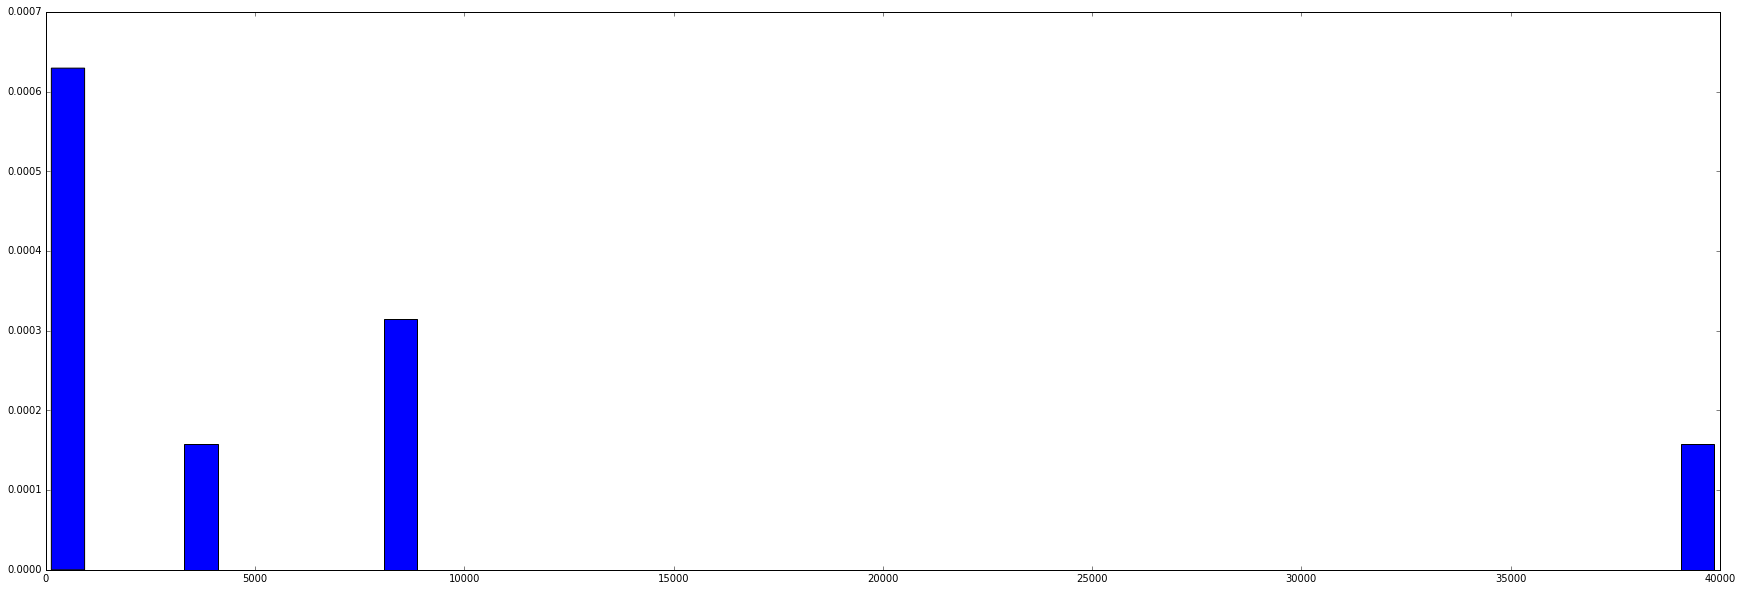

In [32]:
distrib_peak_len(outfile)

**Dataset OK but only contains only 8 peaks in lncRNA. 1 of the peaks is really wide = 40000 pb The dataset contains only the 8 peaks identify in the lncRNA... The coordinates correspond to the gen coordinates rather than the peaks themselves.. Use the dataset?? Is it really worthy to remap everything for such a low number of eventual peaks?** 

### pseudoU_Li_hg38

In [33]:
infile="./PTM_Original_Datasets/pseudoU_Li_hg38.bed"
PMID = "26075521"
cell = "HEK293"
modification = "Y"
method = "CeU_Seq"
author = "Li"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/pseudoU_Li_hg38.bed
Total lines:	1495

0	# Transcriptome-wide map of pseudouridine [hg38 coordinates]
1	# Reference: Li et al., Nat. Chem. Biol. 11, 592 (2015) [PMID 26075521, DOI 10.1038/nchembio.1836]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	1051520	1051521	Li|AGRN|NM_198576|CDS	0	+
7	chr1	1254956	1254957	Li|UBE2J2|NM_194458|3'_UTR	0	-
8	chr1	1298603	1298604	Li|ACAP3|NM_030649|CDS	0	-
9	chr1	1386884	1386885	Li|CCNL2|NM_030937|3'_UTR	0	-

1490	chrX	154765960	154765961	Li|DKC1|NR_110022|noncoding	0	+
1491	chrX	155033408	155033409	Li|FUNDC2|NM_023934|CDS	0	+
1492	chrX	155054648	155054649	Li|FUNDC2|NM_023934|CDS	0	+
1493	chrX	155122200	155122201	Li|BRCC3|NM_024332|3'_UTR	0	+
1494	chrX	155258757	155258758	Li|RAB39B|NM_171998|3'_UTR	0	-

|0|chr1|chr17|chr19|chr11|chr2|chr12|chr3|chrX|chr16|chr6|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:

In [35]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"|",6,"\t",7,"\t",8]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",7,"\t",8]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

1489 Lines processed	1489 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Li_Y_HEK293_hg38_cleaned.bed
Total lines:	1495

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 14:26:25.480994
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=Y|Cell_type=HEK293|Analysis_method=CeU_Seq|Pubmed_ID=26075521
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	1051520	1051521	Y|HEK293|CeU_Seq|26075521|AGRN	0	+
7	chr1	1254956	1254957	Y|HEK293|CeU_Seq|26075521|UBE2J2	0	-
8	chr1	1298603	1298604	Y|HEK293|CeU_Seq|26075521|ACAP3	0	-
9	chr1	1386884	1386885	Y|HEK293|CeU_Seq|26075521|CCNL2	0	-

1490	chrX	154765960	154765961	Y|HEK293|CeU_Seq|26075521|DKC1	0	+
1491	chrX	155033408	155033409	Y|HEK293|CeU_Seq|26075521|FUNDC2	0	+
1492	chrX	155054648	155054649	Y|HEK293|CeU_Seq|26075521|FUNDC2	0	+
1493	chrX	155122200	155122201	Y|H

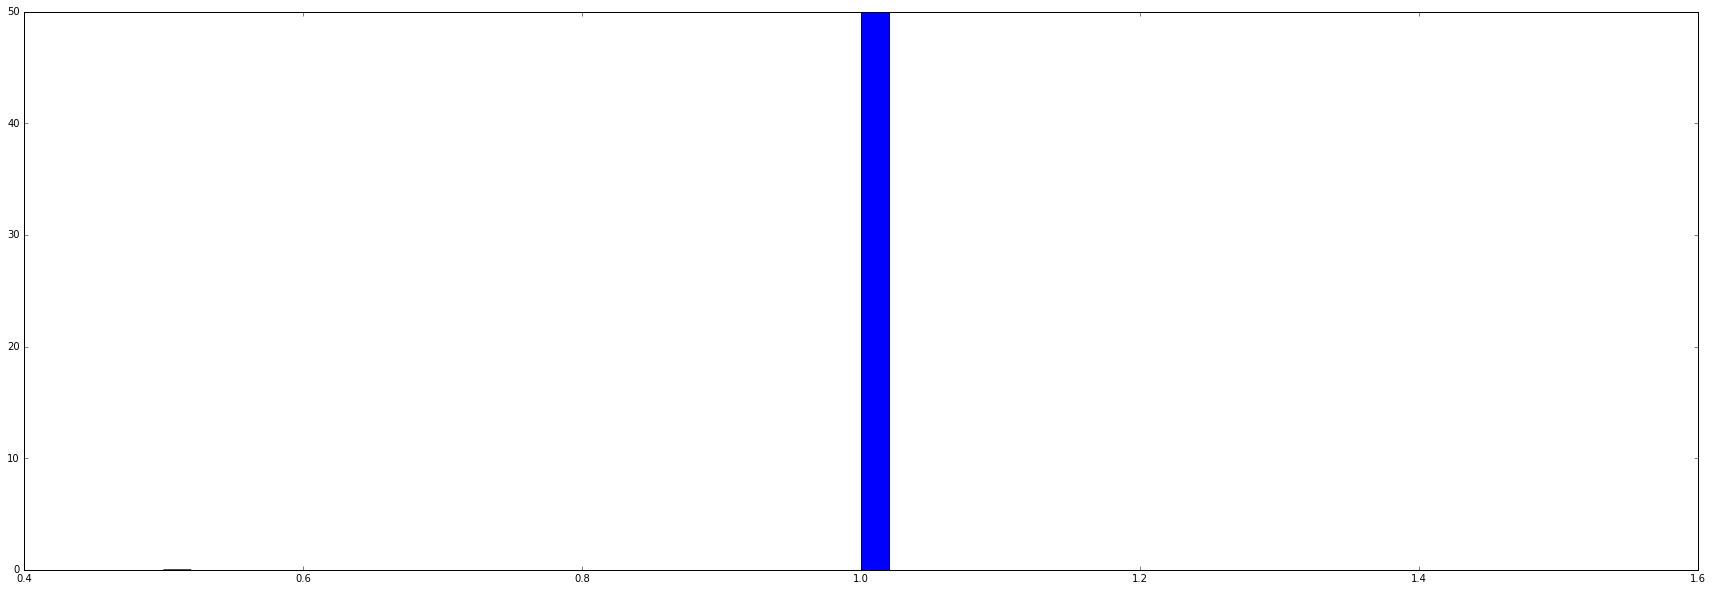

In [34]:
distrib_peak_len(outfile)

**No problem with this dataset**

### pseudoU_Schwartz_hg38

In [35]:
infile="./PTM_Original_Datasets/pseudoU_Schwartz_hg38.bed"
PMID = "25219674"
cell = "HEK293:Fibroblast"
modification = "Y"
method = "Psi-seq"
author = "Schwartz"
outfile = "./PTM_Clean_Datasets/{}_{}_{}_hg38_cleaned.bed".format(author, modification, cell, method)

file_summary(infile)

Filename:	./PTM_Original_Datasets/pseudoU_Schwartz_hg38.bed
Total lines:	402

0	# Transcriptome-wide map of pseudouridine [hg38 coordinates]
1	# Reference: Schwartz et al., Cell 159, 148 (2014) [PMID 25219674, DOI 10.1016/j.cell.2014.08.028]
2	#
3	# Data cleaned and converted to BED6, coordinate conversion to hg38 using liftOver.
4	# Maintainer: Maurits Evers (maurits.evers@anu.edu.au)
5	#
6	chr1	1045799	1045800	Schwartz|AGRN	0	+
7	chr1	6222864	6222865	Schwartz|ICMT	0	-
8	chr1	6623606	6623607	Schwartz|PHF13	0	+
9	chr1	16545956	16545957	Schwartz|TRNA_Gly	0	-

397	chrX	136210827	136210828	Schwartz|FHL1	0	+
398	chrX	153694609	153694610	Schwartz|SLC6A8	0	+
399	chrX	153700577	153700578	Schwartz|BCAP31	0	-
400	chrX	153786900	153786901	Schwartz|IDH3G	0	-
401	chrX	154765960	154765961	Schwartz|DKC1	0	+

|0|chr1|chr12|chr2|chr5|chr17|chr11|chr6|chr3|chrX|chr8|...|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Count|58|30|28|27|25|24|23|22|18|18|...|

|1|23917850|22829934|1547659

In [39]:
# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand\n"

init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"\t",5,"\t",6]
final_template=[0,"\t",1,"\t",2,"\t",modification,"|",cell,"|",method,"|",PMID,"|",4,"\t",5,"\t",6]

reformat_table(
    input_file=infile,
    output_file=outfile,
    init_template=init_template,
    final_template=final_template,
    keep_original_header = False,
    header = generate_header(PMID, cell, modification, method),
    replace_internal_space='_',
    replace_null_val="-")

file_summary(outfile)

396 Lines processed	396 Lines pass	0 Lines filtered out	0 Lines fail

Filename:	./PTM_Clean_Dataset/Schwartz_Y_HEK293:Fibroblast_hg38_cleaned.bed
Total lines:	402

0	# Data cleaned, converted to BED6, coordinate converted to hg38 using liftOver
1	# Maurits Evers (maurits.evers@anu.edu.au)
2	# Data cleaned and standardized. 2016-06-08 14:30:59.408427
3	# Adrien Leger (aleg@ebi.ac.uk)
4	# RNA_modification=Y|Cell_type=HEK293:Fibroblast|Analysis_method=Psi-seq|Pubmed_ID=25219674
5	# chrom	chromstart	chromend	modif|cell_type|method|PMID|loci	score	strand
6	chr1	1045799	1045800	Y|HEK293:Fibroblast|Psi-seq|25219674|AGRN	0	+
7	chr1	6222864	6222865	Y|HEK293:Fibroblast|Psi-seq|25219674|ICMT	0	-
8	chr1	6623606	6623607	Y|HEK293:Fibroblast|Psi-seq|25219674|PHF13	0	+
9	chr1	16545956	16545957	Y|HEK293:Fibroblast|Psi-seq|25219674|TRNA_Gly	0	-

397	chrX	136210827	136210828	Y|HEK293:Fibroblast|Psi-seq|25219674|FHL1	0	+
398	chrX	153694609	153694610	Y|HEK293:Fibroblast|Psi-seq|25219674|SLC6A8	0	+
399	chrX

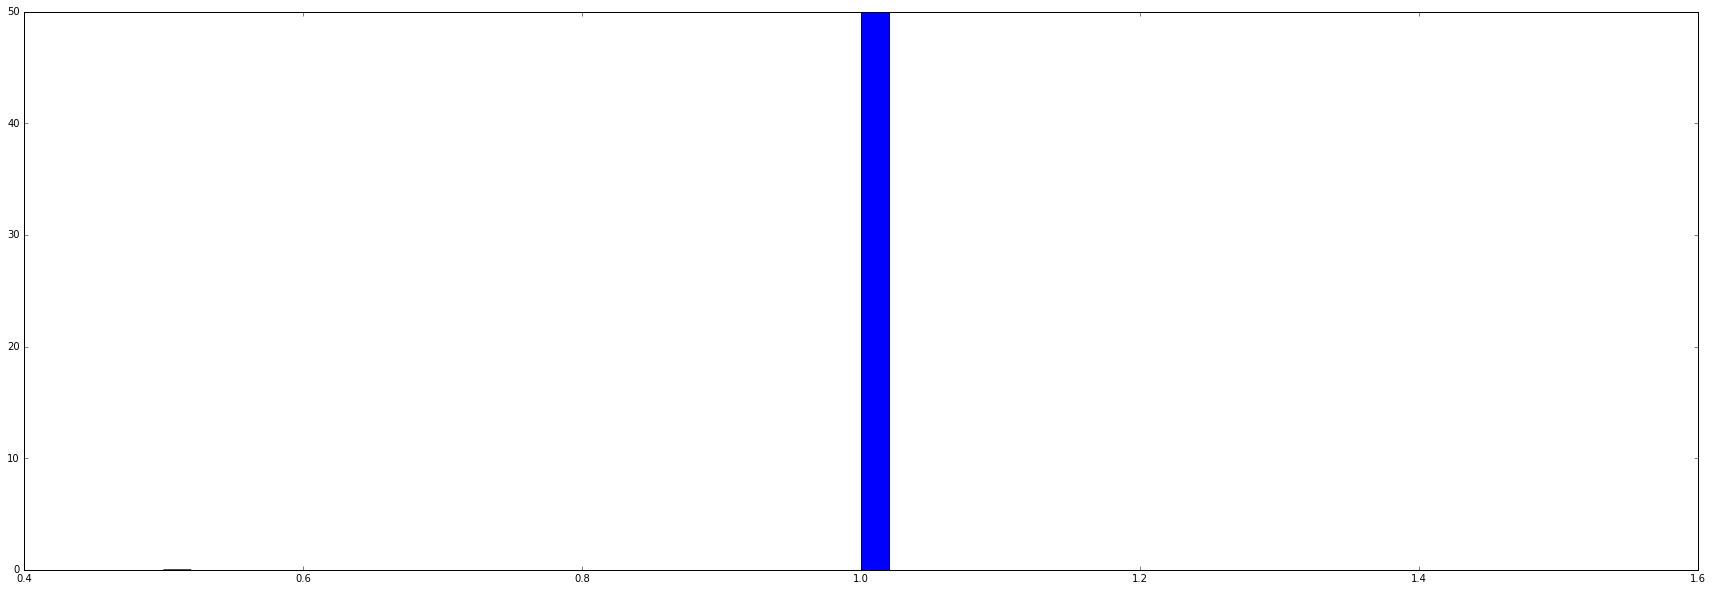

In [36]:
distrib_peak_len(outfile)

**No problem with this dataset**

---
## Summary of the PTM datasets

### Verify datasets homogeneous formating

In [57]:
for f in sorted(glob("./PTM_Clean_Datasets/*.bed")):
    print (f)
    linerange(f, [[10,12]])

./PTM_Clean_Datasets/Carlile_Y_HeLa_hg38_cleaned.bed
10	chr17	16438821	16478678	Y|HeLa|Pseudo_seq|25192136|FAM211A-AS1	1537	+
11	chr2	231455799	231455936	Y|HeLa|Pseudo_seq|25192136|SNROA75	84	-
12	chr6	52995619	52995950	Y|HeLa|Pseudo_seq|25192136|RN7SK	250	+

./PTM_Clean_Datasets/DARNED_human_hg38_inosine_cleaned.bed
10	chr4	482698	482698	A>I|THYMUS|-|15342557|ZNF721	0	-
11	chr4	482700	482700	A>I|THYMUS|-|15342557|ZNF721	0	-
12	chr4	482737	482737	A>I|THYMUS|-|15342557|ZNF721	0	-

./PTM_Clean_Datasets/Dominissini_m1A_HeLa:HEK293:HepG2_hg38_cleaned.bed
10	chr1	826862	826863	m1A|HepG2|M1A_seq|26863196|NR_024321	0	-
11	chr1	827681	827682	m1A|HepG2|M1A_seq|26863196|NR_047524	0	+
12	chr1	942192	942193	m1A|HeLa|M1A_seq|26863196|NM_152486	0	+

./PTM_Clean_Datasets/Dominissini_m6A_HepG2_hg38_cleaned.bed
10	chr1	460876	461815	m6A|HepG2|M6A_seq|22575960|OR4F16	-	-
11	chr1	622631	623325	m6A|HepG2|M6A_seq|22575960|X64709	+	+
12	chr1	623326	623396	m6A|HepG2|M6A_seq|22575960|M37726	+	+

./PTM_Clean_D

**OK for all the datasets**

### Summary of the datasets 

In [58]:
for f in sorted(glob("./PTM_Clean_Datasets/*.bed")):
    print ("\n", "-"*100)
    print ("Dataset Name\t{}".format(basename(f)))
    print ("Number sites\t{}".format(simplecount(f, ignore_hashtag_line=True)))
    a = colsum(
        f,
        colrange = [3,4,5,6],
        header=False,
        ignore_hashtag_line=True,
        separator=["\t", "|"],
        max_items=20,
        ret_type="dict"
    )
    
    # Get more info via pubmed
    print ("PMID")
    for pmid,count in a[6].items():
        pubmed_info = pmid_to_info(pmid)
        print ("\t*{}\t{}\n\t {}. et al, {}\{}\{}\n\t {}".format(
                pmid,count,
                pubmed_info["first_name"],
                pubmed_info["Year"],
                pubmed_info["Month"],
                pubmed_info["Day"],
                pubmed_info["title"]))
    
    # Simple listing for the other fields
    for title, col in [["RNA PTM",3],["Tissue/cell",4],["Method",5]]:
        print (title)
        print(dict_to_report(a[col], ntab=1, max_items=10, tab="\t", sep="\t"))


 ----------------------------------------------------------------------------------------------------
Dataset Name	Carlile_Y_HeLa_hg38_cleaned.bed
Number sites	8
PMID
	*25192136	8
	 Carlile. et al, 2014\09\05
	 Pseudouridine profiling reveals regulated mRNA pseudouridylation in yeast and human cells.
RNA PTM
	Y	8

Tissue/cell
	HeLa	8

Method
	Pseudo_seq	8


 ----------------------------------------------------------------------------------------------------
Dataset Name	DARNED_human_hg38_inosine_cleaned.bed
Number sites	289998
PMID
	*19478186	412
	 Li. et al, NA\NA\NA
	 Genome-wide identification of human RNA editing sites by parallel DNA capturing and sequencing.
	*15342557	31489
	 Kim. et al, NA\NA\NA
	 Widespread RNA editing of embedded alu elements in the human transcriptome.
	*15258596	3954
	 Levanon. et al, 2004\07\18
	 Systematic identification of abundant A-to-I editing sites in the human transcriptome.
	*21960545	11164
	 Bahn. et al, 2011\09\29
	 Accurate identification of A-

# Gene annotation of the PTM datasets

** The original annotations might not be optimal, and probably not made from an uniq reference annotation file. I will reanotate all the datasets will the last version of gencodegencode.v24.long_noncoding_RNAs.gff3. I split the file in 3 to retain only genes, transcript and exons. I also got the general gencode file containing all the annotated genes in the primary assembly**

 * gencodegencode.v24.long_noncoding_RNAs = Contains the comprehensive gene annotation of lncRNA genes on the reference chromosomes 
 * gencode.v24.annotation = Contains the comprehensive gene annotation on the primary assembly (chromosomes and scaffolds) sequence regions

In [120]:
# New dir to create annotated files 
mkdir("PTM_Annotated_Datasets")
mkdir("Test")

'Test'

** I found a python wrapper package for bedtools to manipulate bed files. I will use it to intersect my bed files containing the positions of the PTM (or peaks) and the gff3 annotation files. This will allow me to get gene names for each positions **

In [127]:
import pybedtools

def intersect_extract_genecodeID (annotation_file, peak_file, outdir):
    
    output_file = "{}/{}_{}.bed".format(outdir, file_basename(peak_file), file_basename(annotation_file))
    genecount_file = "{}/{}_{}_uniq-gene.csv".format(outdir, file_basename(peak_file), file_basename(annotation_file))
    site_file = "{}/{}_{}_uniq-sites.csv".format(outdir, file_basename(peak_file), file_basename(annotation_file))
    
    peak = pybedtools.BedTool(peak_file)
    annotation = pybedtools.BedTool(annotation_file)
    
    # Intersect the 2 files with pybedtools
    print("Intersecting {} with {}".format(file_basename(peak_file), file_basename(annotation_file)))
    intersection = peak.intersect(annotation, wo=True, s=True)

    # Reformat the file generated by pybedtools to a simple Bed format
    init_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"|",6,"|",7,"\t",8,"\t",9,"\t",10,"\t",11,"\t",12,"\t",13,
                   "\t",14,"\t",15,"\t",16,"\t",17,"\tID=",18,";gene_id=",19,";gene_type=",20,";gene_status=",21,
                   ";gene_name=",22,";level=",23,";havana_gene=",24]

    final_template=[0,"\t",1,"\t",2,"\t",3,"|",4,"|",5,"|",6,"|",18,"|",20,"|",22,"\t",8,"\t",9]
    
    h = "# Data cleaned, converted to BED6, standardized and coordinates converted to hg38 using liftOver\n"
    h+= "# Overlaping gene annotation with gencodev23"
    h+= "# Adrien Leger (aleg@ebi.ac.uk) {}".format(str (datetime.datetime.today()))
    h+= "# chrom\tchromstart\tchromend\tmodif|cell_type|method|PMID|ensembl_id|gene_type|gene_name\tscore\tstrand\n"
    
    print("Post processing results")
    reformat_table(
        input_file=intersection.fn,
        output_file=output_file,
        init_template=init_template,
        final_template=final_template,
        replace_internal_space='_',
        replace_null_val="-",
        header = h,
        keep_original_header = False,
    )
    
    # Count the number of lines in the initial and final peak files
    i, j = simplecount(peak_file, ignore_hashtag_line=True), simplecount(output_file, ignore_hashtag_line=True)
    print("Total initial positions: {}\tTotal final positions: {}".format(i, j))
         
    # Count uniq gene id and uniq positions found in the dataset 
    geneid_dict = OrderedDict()
    coord_dict = OrderedDict()
    
    with open (output_file, "r") as fp:
        for line in fp:
            if line[0] != "#":
                sl= supersplit(line, separator=["\t", "|"])
                
                gene_id = "{}\t{}".format(sl[7],sl[9])
                if gene_id not in geneid_dict:
                    geneid_dict[gene_id] = 0
                geneid_dict[gene_id] += 1
                
                coord = "{}:{}-{}".format(sl[0],sl[1],sl[2])
                if coord not in coord_dict:
                    coord_dict[coord] = 0
                coord_dict[coord] += 1
                
        print ("Uniq genes found\t{}\nUniq position found\t{}\n".format(
                len(geneid_dict.values()), len(coord_dict.values()) ))
    
    # Write each gene id found with the number of time found 
    with open (genecount_file, "w") as fp:
        fp.write(dict_to_report (geneid_dict, max_items=0, sep="\t"))

    # Write each gene id found with the number of time found 
    with open (site_file, "w") as fp:
        fp.write(dict_to_report (coord_dict, max_items=0, sep="\t"))


**Add the gene name and ensembl gene ID to the bed name field**

**Test with one file **

In [128]:
annotation_file = "../Reference_Annotation/gencode_v24_gene.gff3"
peak_file = "./PTM_Clean_Datasets/Carlile_Y_HeLa_hg38_cleaned.bed"
outdir = "./Test"

output_file = "./Test/Carlile_Y_HeLa_hg38_cleaned_gencode_v24_gene.bed"
genecount_file = "./Test/Carlile_Y_HeLa_hg38_cleaned_gencode_v24_gene_uniq-gene.csv"
site_file = "./Test/Carlile_Y_HeLa_hg38_cleaned_gencode_v24_gene_uniq-sites.csv"

intersect_extract_genecodeID (annotation_file, peak_file, outdir)
file_summary(output_file, separator=["\t","|"])

head (genecount_file)
head (site_file)

remove(output_file)
remove(genecount_file)
remove(site_file)

Intersecting Carlile_Y_HeLa_hg38_cleaned with gencode_v24_gene
Post processing results
25 Lines processed	25 Lines pass	0 Lines filtered out	0 Lines fail
Total initial positions: 8	Total final positions: 25
Uniq genes found	22
Uniq position found	7

Filename:	./Test/Carlile_Y_HeLa_hg38_cleaned_gencode_v24_gene.bed
Total lines:	27

0	# Data cleaned, converted to BED6, standardized and coordinates converted to hg38 using liftOver
1	# Overlaping gene annotation with gencodev23# Adrien Leger (aleg@ebi.ac.uk) 2016-06-15 15:57:36.030536# chrom	chromstart	chromend	modif|cell_type|method|PMID|ensembl_id|gene_type|gene_name	score	strand
2	chr11	62851987	62855914	Y|HeLa|Pseudo_seq|25192136|ENSG00000255717.6|processed_transcript|SNHG1	1766	-
3	chr11	62851987	62855914	Y|HeLa|Pseudo_seq|25192136|ENSG00000277194.1|snoRNA|SNORD22	1766	-
4	chr11	62851987	62855914	Y|HeLa|Pseudo_seq|25192136|ENSG00000277846.1|snoRNA|SNORD30	1766	-
5	chr11	62851987	62855914	Y|HeLa|Pseudo_seq|25192136|ENSG00000278527.1|sn

**It is working ok > looping over all the cleaned PTM files**

In [130]:
# Annotation vs gencodev23 lncRNA genes
annotation_file = "../Reference_Annotation/gencode_v24_lncRNAs_gene.gff3"

for peak_file in sorted(glob("./PTM_Clean_Datasets/*.bed")):
    outdir = "./PTM_Annotated_Datasets"
    intersect_extract_genecodeID (annotation_file, peak_file, outdir)

Intersecting Carlile_Y_HeLa_hg38_cleaned with gencode_v24_lncRNAs_gene
Post processing results
4 Lines processed	4 Lines pass	0 Lines filtered out	0 Lines fail
Total initial positions: 8	Total final positions: 4
Uniq genes found	3
Uniq position found	3

Intersecting DARNED_human_hg38_inosine_cleaned with gencode_v24_lncRNAs_gene
Post processing results
24152 Lines processed	24152 Lines pass	0 Lines filtered out	0 Lines fail
Total initial positions: 289998	Total final positions: 24152
Uniq genes found	1300
Uniq position found	19814

Intersecting Dominissini_m1A_HeLa:HEK293:HepG2_hg38_cleaned with gencode_v24_lncRNAs_gene
Post processing results
606 Lines processed	606 Lines pass	0 Lines filtered out	0 Lines fail
Total initial positions: 19552	Total final positions: 606
Uniq genes found	338
Uniq position found	578

Intersecting Dominissini_m6A_HepG2_hg38_cleaned with gencode_v24_lncRNAs_gene
Post processing results
115 Lines processed	115 Lines pass	0 Lines filtered out	0 Lines fail
Tota

**Between 1 and 16% (excluding the weird carlile dataset) of the peaks are found in lncRNA annotated in gencode v23.
Iterate through the datasets to find the number of uniq genes found**

In [131]:
# Annotation vs gencodev23 All genes
annotation_file = "../Reference_Annotation/gencode_v24_gene.gff3"

for peak_file in sorted(glob("./PTM_Clean_Datasets/*.bed")):
    outdir = "./PTM_Annotated_Datasets"
    intersect_extract_genecodeID (annotation_file, peak_file, outdir)

Intersecting Carlile_Y_HeLa_hg38_cleaned with gencode_v24_gene
Post processing results
25 Lines processed	25 Lines pass	0 Lines filtered out	0 Lines fail
Total initial positions: 8	Total final positions: 25
Uniq genes found	22
Uniq position found	7

Intersecting DARNED_human_hg38_inosine_cleaned with gencode_v24_gene
Post processing results
294441 Lines processed	294441 Lines pass	0 Lines filtered out	0 Lines fail
Total initial positions: 289998	Total final positions: 294441
Uniq genes found	10558
Uniq position found	254964

Intersecting Dominissini_m1A_HeLa:HEK293:HepG2_hg38_cleaned with gencode_v24_gene
Post processing results
20786 Lines processed	20786 Lines pass	0 Lines filtered out	0 Lines fail
Total initial positions: 19552	Total final positions: 20786
Uniq genes found	8516
Uniq position found	19063

Intersecting Dominissini_m6A_HepG2_hg38_cleaned with gencode_v24_gene
Post processing results
1080 Lines processed	1080 Lines pass	0 Lines filtered out	0 Lines fail
Total initial po

### Overall summary of the analysis compared with results reported in Shafik et al

|Article|Modification|Total sites initial (Shafik)| Total sites final|All sites in RNA|Uniq sites in RNA|Uniq RNA with site|All sites in lncRNA (Shafik)|Uniq sites in lncRNA|Uniq lncRNA with site (Shafik)|
|---|---|---|---|---|---|---|---|---|---|
|Peng et al|Inosine|22686 (22686)|21,111 |18,827 |17,081 |4,034 |3382 (4425)|3259|505 (846)|
|Sakurai et al|Inosine|20482 (20482)|20,482 |19,906 |17,230 |2,648 |2550 (3050)|2330|319 (400)|
|Hussain et al|m5C|1084 (1084)|1,084 |332 |296 |158 |107 (110)|106|39 (41)|
|Khoddami et al|m5C|20553 (20533)|20,553 |14,234 |12,011 |321 |1523 (1580)|1523|36 (38)|
|Squires et al.|m5C|10490 (10490)|10,490 |11,038 |10,169 |4,659 |281 (1544)|272|112 (711)|
|Dominissini et al.|m6A|25918 (25776)|2,894 |1,080 |1,019 |466 |115 (7397)|114|84 (6165)|
|Meyer et al|m6A|4341 (4341)|4,341 |4,564 |4,312 |1,525 |48 (57)|48|16 (20)|
|Linder et al|m6A and m6Am|15167 (NA)|15,167 |15,945 |14,851 |6,191 |385 (NA)|375|168 (NA)|
|Dominissini et al.|m1A|32136 (NA)|19552 (HeLa:8873, HepG2:8550, HEK293:2129)|20,786 |19,063 |8,516 |606 (NA)|578|338 (NA)|
|Carlile et al|pseudouridylation|8 (8)|8 |25 |7 |22 |4 (4)|3|3 (3)|
|Li et al|pseudouridylation|1489 (1489)|1,489 |1,579 |1,471 |1,425 |48 (58)|47|44 (54)|
|Schwartz et al|pseudouridylation|402 (396)|402 |421 |372 |378 |14 (15)|14|10 (11)|
|DARNED|Inosine|333216 (259654)|290,002 |294,441 |254,964 |10,558 |24152 (23574)|19814|1300 (1833)|
|RADAR|Inosine|2576460 (2576289)|1,342,374 |1,372,609 |918,049 |17,532 |97118 (218793)|68396|3343 (6376)|


**I obtained less peaks and less uniq genes than shafik et al, probably since I used more stringent criteria for filtering and cleaning (especially for dominissini 2012 paper). Overall the results are consistant though for later analysis I will probably have to go back from the data for several papers.**

---
# Subcellular cell localization datasets


---
## Cabili = HT-FISH data

***Cabili, M. N. et al. Localization and abundance analysis of human lncRNAs at single-cell and single-molecule resolution. Genome Biol 16, (2015)***

- Subcellular Location of lncRNA by RNA FISH
- Nice dataset with Human foreskin fibloblast (hFFs), Human lung fibroblast (hLFs) and HeLA cells
- Limited to a very number of candidate = 34 only
- Could be a good control datasets if we stick to Hela cells

**The only data available are a large multitab excel file containing a lot of messy information. The annotation are based on different database (lncipedia or Noncode, or refSeq and rarely ensembl)... sometime the lncRNA is only described in one database and not in ensembl. First I obtained the common name for all lncRNA from lncipedia. However it was impossible to get the Ensembl equivalent in most of the cases.**

**Fortunatly they provide all the probe they used to fish the lncRNA. So when the information is not available I have to blast the probe in Ensemble to get the proper gene corresponding to the probes... It is a long and painfull work, but this dataset is going to be my reference for future localization experient so it has to be done properly**

In [6]:
from collections import OrderedDict

d = OrderedDict()

for line in open("./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/All_probes.csv", 'r'):
    sequence, seq_name, gene_num = line.split("\t")
    d[gene_num]=seq_name.rpartition("_")[0]

for k,v in d.items():
    print ("{}\t{}".format(k.strip(),v))

1	XLOC_004198
2	XLOC_009233
3	NR_024412
4	NM_000272
5	XLOC_004456
6	NR_015370
7	XLOC_I2_010926
8	NR_024031
9	NR_038322
10	NR_027063
11	XLOC_009474
12	XLOC_004198
13	XLOC_009233
14	NR_024412
15	NM_000272
16	XLOC_004456
17	NR_015370
18	XLOC_I2_010926
19	NR_024031
20	NR_038322
21	NR_027063
22	XLOC_009474
23	XLOC_L2_008203
24	XLOC_012564
25	XLOC_012197
26	XLOC_012046_(exonsuniquetoNR_036444)
27	XLOC_011264
28	XLOC_010709
29	XLOC_010556
30	XLOC_009702
31	XLOC_009662
32	XLOC_009447
33	XLOC_008583
34	XLOC_008174
35	XLOC_005764
36	XLOC_005151
37	XLOC_004803
38	XLOC_004122
39	XLOC_003526
40	XLOC_002408
41	XLOC_002094
42	XLOC_000304
43	NR_033857exons0-2
44	NM_139078(XLOC_010202_neighbor)
45	NM_023000(NR_029435_neighbor)
46	XLOC_013841
47	XLOC_012046(exonsuniquetoNR_033925)
48	XLOC_010263
49	NM_005853(XLOC_011950_neighbor)
50	NM_000820_neighbor_of_XLOC_010514
51	ANCR
52	lincFOXF1
53	lincSFPQ
54	lincDR1
55	lincTUG1
56	lincGARS
57	lincMKLN1_A
58	ANRil
59	GAS5
60	Kcnq1ot1
61	Meg3
62	NR_033857(part n

In [17]:
# Extract the sequences of the probles for each gene in a separate file
from collections import OrderedDict
from pprint import pprint as pp
import random

def get_fasta_probes(infile, outfile, id_list=[]):
    
    seq_dict = OrderedDict()
    for line in open (infile, "r"):
        sequence, seq_name, gene_num = line.split("\t")
        gene_name, sep, seq_num = seq_name.rpartition("_")
        
        for id in id_list:
            if (type(id) == int and id == int(gene_num)) or (type(id) == str and id == gene_id):
                seq_dict[seq_name] = sequence

    # if sequences were found = write the a maximum of 30 randomly picked sequence in an outfile
    if seq_dict:
        key_list = list(seq_dict.keys())
        random.shuffle(key_list)
        
        with open (outfile, "w") as fp:
            for key in key_list[0:30]:
                fp.write(">{}\n{}\n".format(key, seq_dict[key]))

In [18]:
infile = "./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/All_probes.csv"

# Creating a file contaning the probe used for each 34 valid experimental designs
d ={"DANCR":[51, 8, 19],
    "CDKN2B-AS1":[58],
    "GAS5":[59],
    "KCNQ1OT1":[60],
    "FENDRR":[26, 47, 52, 95],
    "LINC-PINT":[57],
    "lnc-SFPQ-2":[53],
    "MALAT1":[92],
    "MEG3":[61],
    "NEAT1":[64],
    "LINC00998":[3, 14],
    "PSMA3-AS1":[85],
    "lnc-AC078802.1-2":[65],
    "TUG1":[55],
    "XIST":[67],
    "lnc-NRXN1-2":[41],
    "LINC01116":[40],
    "DUBR":[73],
    "lnc-GRXCR1-4":[39],
    "TMEM161B-AS1":[5, 16],
    "lnc-C5orf39-2":[37],
    "lnc-RREB1-4":[36],
    "LINC00472":[35],
    "PVT1":[72],
    "LINC01278":[34],
    "RAB30-AS1":[2, 13],
    "LINC00941":[30],
    "lnc-MAGOHB-1":[77],
    "GAS6-AS2":[82],
    "lnc-SNURF-1":[84],
    "OIP5-AS1":[68],
    "CRNDE":[74],
    "lnc-USP14-2":[76,87],
    "MIR4435-2HG":[23]}

for gene_name, id_list in d.items():
    outfile = "./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_{}.fa".format(gene_name)
    get_fasta_probes(infile, outfile, id_list)
    print ("Created " + outfile)

Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-USP14-2.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_MIR4435-2HG.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-MAGOHB-1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_MEG3.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-NRXN1-2.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_TMEM161B-AS1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_CDKN2B-AS1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-C5orf39-2.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_TUG1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_KCNQ1OT1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-AC078802.1-2.fa
Created ./Localisat

** Each file was blasted against ensembl human genomic sequence hgrh38. I manually checked the overlapping genes and the position of hits relative to exons. Finally I reported the corresponding ensembl ID. In 2 conditions I was nor able to find a gene in the ensembl build at the position indicated by the probes. Instead in fond genes only described in NCBI genes. Trom what I saw in the blast results, all of the genes identified are not lncRNA. I compared the ensembl gene ID found with the gencodev23 file containing all the genes. Results are summarized in the table thereafter**

In [132]:
from collections import OrderedDict

def parse_ensembl_annotation (annotation_file):

    annotation_dict = OrderedDict()
    # Ensembl gen decomposing template
    template=[0,"\t",1,"\t",2,"\t",3,"\t",4,"\t",5,"\t",6,"\t",7,"\tID=",8,";gene_id=",9,";gene_type=",10,
              ";gene_status=",11,";gene_name=",12,";level=",13,";havana_gene=",14]
    
    # Parsing annotation file in a dict
    with open (annotation_file, "r") as fp:
        for line in fp:
            if line[0] != "#":
                sl = _decompose_line(line, template)       
                if sl[2] == "gene":
                    id = sl[8].split(".")[0]
                    assert id not in annotation_dict, "Duplicated gene ID !! Fuck" 
                    annotation_dict[id] = {
                        "seqid":sl[0],"source":sl[1],"type":sl[2],"start":sl[3],"end":sl[4],"score":sl[5],
                        "strand":sl[6],"phase":sl[7],"ID":sl[8],"gene_id":sl[9],"gene_type":sl[10],
                        "gene_status":sl[11],"gene_name":sl[12],"level":sl[13],"havana_gene":sl[14]}
    
    return annotation_dict

def annotate_ensembl_ID (annotation_file, candidate_file, out_file):
    
    print ("Parsing annotation file ...")
    annotation_dict = parse_ensembl_annotation(annotation_file)
    
    print ("Searching for candidates ...")
    with open (candidate_file, "r") as cf, open (out_file, "w") as of:
        of.write("#Gen_screenID\tGene_name\tEnsemb_ID\tseqid\tsource\ttype\tstart\tend\tscore\tstrand\tphase\tID\tgene_id\tgene_type\tgene_status\tgene_name\tlevel\thavana_gene\n")                
        
        for line in cf:
            if line[0] != "#":
                line = line.strip()
                sl= line.split("\t")           
                if sl[2] in annotation_dict:
                    of.write ("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
                            line,
                            annotation_dict[sl[2]]["seqid"].strip(),
                            annotation_dict[sl[2]]["source"].strip(),
                            annotation_dict[sl[2]]["type"].strip(),
                            annotation_dict[sl[2]]["start"].strip(),
                            annotation_dict[sl[2]]["end"].strip(),
                            annotation_dict[sl[2]]["score"].strip(),
                            annotation_dict[sl[2]]["strand"].strip(),
                            annotation_dict[sl[2]]["phase"].strip(),
                            annotation_dict[sl[2]]["ID"].strip(),
                            annotation_dict[sl[2]]["gene_id"].strip(),
                            annotation_dict[sl[2]]["gene_type"].strip(),
                            annotation_dict[sl[2]]["gene_status"].strip(),
                            annotation_dict[sl[2]]["gene_name"].strip(),
                            annotation_dict[sl[2]]["level"].strip(),
                            annotation_dict[sl[2]]["havana_gene"].strip()))
                else:
                    of.write ("{}\t{}\n".format(line, "NOT_FOUND"))                   

In [134]:
# Request annotation for all candidates in lncRNA Gencode database
annotation_file = "../Reference_Annotation/gencode_v24_lncRNAs_gene.gff3"
candidate_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/candidate_list.csv"
out_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/candidate_list_annotated.csv"
annotate_ensembl_ID (annotation_file, candidate_file, out_file)

head(out_file, 5)

Parsing annotation file ...
Searching for candidates ...
#Gen_screenID	Gene_name	Ensemb_ID	seqid	source	type	start	end	score	strand	phase	ID	gene_id	gene_type	gene_status	gene_name	level	havana_gene
ANCR	DANCR	ENSG00000226950	chr4	HAVANA	gene	52712404	52720351	.	+	.	ENSG00000226950.6	ENSG00000226950.6	processed_transcript	KNOWN	DANCR	2;tag=ncRNA_host	OTTHUMG00000154670.3
Anril	CDKN2B-AS1	ENSG00000240498	chr9	HAVANA	gene	21994778	22121097	.	+	.	ENSG00000240498.6	ENSG00000240498.6	antisense	KNOWN	CDKN2B-AS1	1;tag=ncRNA_host	OTTHUMG00000019689.3
GAS5	GAS5	ENSG00000234741	chr1	HAVANA	gene	173863900	173868882	.	-	.	ENSG00000234741.7	ENSG00000234741.7	processed_transcript	KNOWN	GAS5	2	OTTHUMG00000037216.5
Kcnq1ot1	KCNQ1OT1	ENSG00000269821	chr11	HAVANA	gene	2608328	2699994	.	-	.	ENSG00000269821.1	ENSG00000269821.1	antisense	KNOWN	KCNQ1OT1	2	OTTHUMG00000171022.2


In [138]:
# Request annotation for all candidates in all Gencode database
annotation_file = "../Reference_Annotation/gencode_v24_gene.gff3"
candidate_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/candidate_list.csv"
out_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/candidate_list_annotated.csv"
annotate_ensembl_ID (annotation_file, candidate_file, out_file)

head(out_file, 5)

Parsing annotation file ...
Searching for candidates ...
#Gen_screenID	Gene_name	Ensemb_ID	seqid	source	type	start	end	score	strand	phase	ID	gene_id	gene_type	gene_status	gene_name	level	havana_gene
ANCR	DANCR	ENSG00000226950	chr4	HAVANA	gene	52712404	52720351	.	+	.	ENSG00000226950.6	ENSG00000226950.6	processed_transcript	KNOWN	DANCR	2;tag=ncRNA_host	OTTHUMG00000154670.3
Anril	CDKN2B-AS1	ENSG00000240498	chr9	HAVANA	gene	21994778	22121097	.	+	.	ENSG00000240498.6	ENSG00000240498.6	antisense	KNOWN	CDKN2B-AS1	1;tag=ncRNA_host	OTTHUMG00000019689.3
GAS5	GAS5	ENSG00000234741	chr1	HAVANA	gene	173863900	173868882	.	-	.	ENSG00000234741.7	ENSG00000234741.7	processed_transcript	KNOWN	GAS5	2	OTTHUMG00000037216.5
Kcnq1ot1	KCNQ1OT1	ENSG00000269821	chr11	HAVANA	gene	2608328	2699994	.	-	.	ENSG00000269821.1	ENSG00000269821.1	antisense	KNOWN	KCNQ1OT1	2	OTTHUMG00000171022.2


**The 2 non-Ensembl lncRNA were not matched. As for the other 29 belong to the lncRNA class (processed_transcript, antisense, lincRNA), 1 is protein_coding and 2 are transcribed_unprocessed_pseudogene that do no belong to the lncRNA class. I think I will still keep a track of the pseudogene, since thay could also have a particular interest later in the analysis. So I have a final number of 29 valid lncRNA + 3 pseudogenes in the final dataset**

|#Gen_screenID|Gene_name|Ensemb_ID|gene_type|lncRNA_class|seqid|start|end|strand|
|---|---|---|---|---|---|---|---|---|
|ANCR|DANCR|ENSG00000226950|processed_transcript|YES|chr4|52712404|52720351|+|
|Anril|CDKN2B-AS1|ENSG00000240498|antisense|YES|chr9|21994778|22121097|+|
|GAS5|GAS5|ENSG00000234741|processed_transcript|YES|chr1|173863900|173868882|-|
|Kcnq1ot1|KCNQ1OT1|ENSG00000269821|antisense|YES|chr11|2608328|2699994|-|
|XLOC_012046|FENDRR|ENSG00000268388|lincRNA|YES|chr16|86474529|86509099|-|
|lincMKLN1_A1|LINC-PINT|ENSG00000231721|antisense|YES|chr7|130941760|131110176|-|
|lincSFPQ|SFPQ|ENSG00000116560|protein_coding|NO|chr1|35176378|35193148|-|
|MALAT1|MALAT1|ENSG00000251562|lincRNA|YES|chr11|65497762|65506516|+|
|Meg3|MEG3|ENSG00000214548|lincRNA|YES|chr14|100779410|100861031|+|
|NEAT1|NEAT1|ENSG00000245532|lincRNA|YES|chr11|65422774|65445540|+|
|NR_024412|LINC00998|ENSG00000214194|lincRNA|YES|chr7|113116718|113118613|-|
|NR_029435|PSMA3-AS1|ENSG00000257621|antisense|YES|chr14|58265365|58298134|-|
|TERC|TERC|ENSG00000270141|lincRNA|YES|chr3|169764520|169765060|-|
|XLOC_014209|TUG1|ENSG00000253352|antisense|YES|chr22|30970677|30979395|+|
|XLOC_008185|XIST|ENSG00000229807|lincRNA|YES|chrX|73820651|73852753|-|
|XLOC_002094|AC007682.1|ENSG00000231918|lincRNA|YES|chr2|51032601|52407917|+|
|XLOC_002408|LINC01116|ENSG00000163364|lincRNA|YES|chr2|176629589|176637931|-|
|XLOC_002746|DUBR|ENSG00000243701|lincRNA|YES|chr3|107240692|107326964|+|
|XLOC_003526|RP11-1E6.1|ENSG00000250657|processed_transcript|YES|chr4|43340875|43345600|+|
|XLOC_004456|TMEM161B-AS1|ENSG00000247828|antisense|YES|chr5|88268895|88436685|+|
|XLOC_004803|REFSEQ-FLJ32255|LOC643977|NA|NA|NA|NA|NA|NA|
|XLOC_005151|NCBI-105374902|LOC105374902|NA|NA|NA|NA|NA|NA|
|XLOC_005764|LINC00472|ENSG00000233237|lincRNA|YES|chr6|71344344|71420769|-|
|XLOC_006922|PVT1|ENSG00000249859|lincRNA|YES|chr8|127794533|128101253|+|
|XLOC_008174|LINC01278|ENSG00000235437|processed_transcript|YES|chrX|63343227|63561071|-|
|XLOC_009233|RAB30-AS1|ENSG00000246067|lincRNA|YES|chr11|83072066|83106719|+|
|XLOC_009702|LINC00941|ENSG00000235884|lincRNA|YES|chr12|30795681|30802711|+|
|XLOC_010017|KLRAP1|ENSG00000256667|transcribed_unprocessed_pseudogene|NO|chr12|10588063|10599669|-|
|XLOC_010514|GAS6-AS2|ENSG00000272695|lincRNA|YES|chr13|113864168|113866833|+|
|XLOC_011185|SNHG14|ENSG00000224078|processed_transcript|YES|chr15|24978583|25419462|+|
|XLOC_011226|OIP5-AS1|ENSG00000247556|processed_transcript|YES|chr15|41283990|41309737|+|
|XLOC_011950|CRNDE|ENSG00000245694|lincRNA|YES|chr16|54918863|54929189|-|
|XLOC_012599|ROCK1P1|ENSG00000263006|transcribed_unprocessed_pseudogene|NO|chr18|109065|122219|+|
|XLOC_L2_008203|MIR4435-2HG|ENSG00000172965|lincRNA|YES|chr2|111196350|111495100|-|



**I removed the data from the protein coding and non ensembl gene and crosmatch them with the experimental data in a simple 3 column csv file (Ensembl-ID : Cell type : localization code). I will create a bedfile containing the coordinate of the gene with additional information fetched from the gencodev23 annotation file. The idea is to obtain a standardize file similar to the bed file created previously for PTM.**

In [156]:
def Bed_ensembl_ID (annotation_file, localization_file, out_file):
        
    print ("Parsing annotation file ...")
    annotation_dict = parse_ensembl_annotation(annotation_file)
    
    h = "# Data cleaned, converted to BED6, standardized, hg38 coordinates\n"
    h+= "# Gene annotation scrapped from gencodev23\n"
    h+= "# Adrien Leger (aleg@ebi.ac.uk) {}\n".format(str (datetime.datetime.today()))
    h+= "# Localization type is a numeric code from the original publication\n"
    h+= "# 0 = Invalid detection\n"
    h+= "# 1 = One or 2 large nuclear foci\n"
    h+= "# 2 = Large nuclear foci and single molecules scattered through the nucleus\n"
    h+= "# 3 = Predominantly nuclear, without foci\n"
    h+= "# 4 = Cytoplasmic and nuclear\n"
    h+= "# 5 = Predominantly cytoplasmic\n"
    h+= "# chrom\tchromstart\tchromend\tLocalization_code|cell_type|method|PMID|ensembl_id|gene_type|gene_name\tscore\tstrand\n"
        
    print ("Searching for candidates ...")
    with open (localization_file, "r") as infile, open (out_file, "w") as outfile:
        outfile.write(h)
        total = invalid_loc_code = invalid_ensemble_id = 0
        
        for line in infile:
            if line[0] != "#":
                total+=1        
                sl= line.split("\t")
                ensemble_id = sl[0].strip()
                cell_type = sl[1].strip()
                loc_code = sl[2].strip()
                
                if loc_code == '0':
                    invalid_loc_code+=1
                    continue
                
                if ensemble_id not in annotation_dict:
                    invalid_ensemble_id+=1
                    continue
                    
                outfile.write ("{0}\t{1}\t{2}\t{3}|{4}|{5}|{6}|{7}|{8}|{9}\t{10}\t{11}\n".format(
                    annotation_dict[ensemble_id]["seqid"].strip(),
                    annotation_dict[ensemble_id]["start"].strip(),
                    annotation_dict[ensemble_id]["end"].strip(),
                    loc_code,
                    cell_type,
                    "RNA_FISH",
                    "25630241",
                    ensemble_id,
                    annotation_dict[ensemble_id]["gene_type"].strip(),
                    annotation_dict[ensemble_id]["gene_name"].strip(),
                    "-",
                    annotation_dict[ensemble_id]["strand"].strip()))
    
    print("Total: {}\tInvalid Localization code: {}\tInvalid Ensembl ID: {}".format(total,invalid_loc_code,invalid_ensemble_id))
                                   

In [158]:
# Request annotation for all candidates in all Gencode database (pseudogenes + lncRNA)
annotation_file = "../Reference_Annotation/gencode_v24_gene.gff3"
localization_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/Localization_cell_ensembl.csv"
out_file = "./Localisation_Clean_Datasets/Cabili_RNA_FISH_hg38.bed"

Bed_ensembl_ID (annotation_file, localization_file, out_file)

head (out_file, 15)

Parsing annotation file ...
Searching for candidates ...
Total: 93	Invalid Localization code: 24	Invalid Ensembl ID: 0
# Data cleaned, converted to BED6, standardized, hg38 coordinates
# Gene annotation scrapped from gencodev23
# Adrien Leger (aleg@ebi.ac.uk) 2016-06-15 17:58:10.405934
# Localization type is a numeric code from the original publication
# 0 = Invalid detection
# 1 = One or 2 large nuclear foci
# 2 = Large nuclear foci and single molecules scattered through the nucleus
# 3 = Predominantly nuclear, without foci
# 4 = Cytoplasmic and nuclear
# 5 = Predominantly cytoplasmic
# chrom	chromstart	chromend	Localization_code|cell_type|method|PMID|ensembl_id|gene_type|gene_name	score	strand
chr4	52712404	52720351	4|hela|RNA_FISH|25630241|ENSG00000226950|processed_transcript|DANCR	-	+
chr4	52712404	52720351	4|hLF|RNA_FISH|25630241|ENSG00000226950|processed_transcript|DANCR	-	+
chr4	52712404	52720351	4|hFF|RNA_FISH|25630241|ENSG00000226950|processed_transcript|DANCR	-	+
chr9	2199477

**This last step removed 24 lines out of 93 for genes that had a invalid localization code (0). The data are now stored in a Bed compatible dataset and ready to be used. I am done with this dataset.**

## Djebali =  ENCODE RNA-Seq nuclear/cytoplasmic fractions

### Exploration of the data space

**I just found this new extensive dataset from the ENCODE v2 consortium published in 2012 with RNA-Seq data from various human cell lines in the nucleus and in the cytoplasm. The data were analysed with the previous version of the human genome and would probably have to be remapped completly on the new version of the genome hg38 and using the last GENCODE annotations. I for each cell line I will compare the nuclear vs the cytoplasmic fractions to get the transcript significantly enriched in the nucleus vs the cytoplasm.**

**The content of the dataset is listed bellow** 

**Cell types (include immortalized cell lines, primary cells and embryonic cells)**
* A549
* GM12878
* H1-hESC
* HeLa-S3
* HepG2
* HUVEC
* IMR90
* K562
* MCF-7
* NHEK
* SK-N-SH

**Localization**
* Nucleus / Cytoplasm > Separated using Qiagen RLN buffer
* Cytosol
* Chromatin (K562 only)
* Nucleolus (K562 only)
* Nucleoplasm (K562 only)

** Additional informations**
* RNAs of >200 nt length are selected using the RNeasy MiniElute Cleanup kit
* RNA were split in 2 fractions by polyA + and the polyA - using Oligotex 
* All fractions were pre‐treated with the Ribominus Eukaryotic Kit for RNA‐seq
* PhiX was added at 1% in 
* There are 2 biological replicates for all the samples (except the H1-hESC embyonic cells)
* fastq Paired end reads are in 2 separates files
* bed, Bigwig, sam .. are also available but I only need the fastq since I will remap the data

** Summary of the dataset I will focus on** 

|Cell Line|Localization|RNA Extract|ENCODE Accesion|
|---|---|---|---|
|A549|cytosol|Long PolyA+ RNA|EH002624|
|A549|nucleus|Long PolyA+ RNA|EH002625|
|GM12878|cytosol|Long PolyA+ RNA|EH000147|
|GM12878|nucleus|Long PolyA+ RNA|EH000170|
|H1-hESC|cytosol|Long PolyA+ RNA|EH000151|
|H1-hESC|nucleus|Long PolyA+ RNA|EH000152|
|HeLa-S3|cytosol|Long PolyA+ RNA|EH000171|
|HeLa-S3|nucleus|Long PolyA+ RNA|EH000172|
|HepG2|cytosol|Long PolyA+ RNA|EH000161|
|HepG2|nucleus|Long PolyA+ RNA|EH000158|
|HUVEC|cytosol|Long PolyA+ RNA|EH000156|
|HUVEC|nucleus|Long PolyA+ RNA|EH000157|
|IMR90|cytosol|Long PolyA+ RNA|EH002626|
|IMR90|nucleus|Long PolyA+ RNA|EH002628|
|K562|cytosol|Long PolyA+ RNA|EH000140|
|K562|nucleus|Long PolyA+ RNA|EH000174|
|MCF-7|cytosol|Long PolyA+ RNA|EH002633|
|MCF-7|nucleus|Long PolyA+ RNA|EH002627|
|NHEK|cytosol|Long PolyA+ RNA|EH000166|
|NHEK|nucleus|Long PolyA+ RNA|EH000165|
|SK-N-SH|cytosol|Long PolyA+ RNA|EH002630|
|SK-N-SH|nucleus|Long PolyA+ RNA|EH002631|

### Reference cleaning and Index generation with Kallisto

**It has been a while that I want to use Kalisto, the software designed by Lior Patcher's team to analyse RNA data. I will perform this analysis with the conventional pipeline (STAR) in parallel to compare the results. The data are quite massive, so I will just prototype on my laptop but run the final analysis on the cluster**

**I dl the last reference fasta transcriptome for all RNA and for lncRNA only from the gencode server (v23). I need to clean the fasta Reference sequence from Gencode since they contain a lot of information from the transcript names of each sequences that will hamper the readability of the results. In order to be able to use the gene names and information later; I also need to save all the information contained in the names in a separate file.**  

In [6]:
from gzip import open as gopen

def Gencode_fastaclean_listinfo (gencode_fasta, clean_fasta="gencode_clean.fa.gz", gencode_info="gencode_info.tsv"):
    with gopen (gencode_fasta, "rt") as fasta_in, gopen (clean_fasta, "wt") as fasta_out, open (gencode_info, "wt") as info:
        
        # write header in the info file
        info.write ("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
            "GENCODE_transcript_id", "GENCODE_gene_id", "HAVANA_gene_id", "HAVANA_transcript_id", "transcript_name",
            "gene_name", "length", "RNA_type"))
        
        nline = nseq = 0
        for line in fasta_in:
            nline += 1
            
            if line[0] == ">":
                nseq += 1
                ls = [i.strip() for i in line[1:].split("|")]
                fasta_out.write (">{}\n".format(ls[0]))
                
                # in lncRNA file not RNA type at the end...
                if not ls[7]:
                    ls[7]="NA"
                info.write("\t".join(ls)+"\n")
            
            else:
                fasta_out.write(line)
    
    print ("Parsed {} lines\t Found {} Sequences".format(nline, nseq))

In [7]:
gencode_fasta = "../../Reference_Genomes/gencode.v24.lncRNA_transcripts.fa.gz"
clean_fasta = "../../Reference_Genomes/gencode_v24_lncRNA_transcripts_clean.fa.gz"
gencode_info = "../../Reference_Genomes/gencode_v24_lncRNA_transcripts_info.tsv"

print ("Clean the file and generate the list from IDs\n") 
Gencode_fastaclean_listinfo (gencode_fasta, clean_fasta, gencode_info)

print ("Visualize the result\n")
head(gencode_fasta, 2)
head(clean_fasta, 2)
head(gencode_info, 2)

Clean the file and generate the list from IDs

Parsed 56062 lines	 Found 28031 Sequences
Visualize the result

>ENST00000473358.1|ENSG00000243485.3|OTTHUMG00000000959.2|OTTHUMT00000002840.1|RP11-34P13.3-001|RP11-34P13.3|712|
GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCCTACCCGTGCTTTCTGCTCTGCAGACCCTCTTCCTAGACCTCCGTCCTTTGTCCCATCGCTGCCTTCCCCTCAAGCTCAGGGCCAAGCTGTCCGCCAACCTCGGCTCCTCCGGGCAGCCCTCGCCCGGGGTGCGCCCCGGGGCAGGACCCCCAGCCCACGCCCAGGGCCCGCCCCTGCCCTCCAGCCCTACGCCTTGACCCGCTTTCCTGCGTCTCTCAGCCTACCTGACCTTGTCTTTACCTCTGTGGGCAGCTCCCTTGTGATCTGCTTAGTTCCCACCCCCCTTTAAGAATTCAATAGAGAAGCCAGACGCAAAACTACAGATATCGTATGAGTCCAGTTTTGTGAAGTGCCTAGAATAGTCAAAATTCACAGAGACAGAAGCAGTGGTCGCCAGGAATGGGGAAGCAAGGCGGAGTTGGGCAGCTCGTGTTCAATGGTTTTGTCCGCCTTCCCTGCCTCCTCTTCTGGGGGAGTTAGATCGAGTTGTAACAAGAACATGCCACTGTCTCGCTGGCTGCAGCGTGTGGTCCCCTTACCAGAGTGAGGATGCGAAGAGAAGGTGGCTGTCTGCAAACCAGGAAGAGAGCCCTCACCGGGAACCCGTCCAGCTGCCACCTTGAACTTGGACTTCCAAGCCTCCAGAACTGTGAGGGATAAATGTAT

>ENST00000473358.1
GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCG

In [6]:
gencode_fasta = "../../Reference_Genomes/gencode.v24.transcripts.fa.gz"
clean_fasta = "../../Reference_Genomes/gencode_v24_transcripts_clean.fa.gz"
gencode_info = "../../Reference_Genomes/gencode_v24_transcripts_info.tsv"

print ("Clean the file and generate the list from IDs\n") 
Gencode_fastaclean_listinfo (gencode_fasta, clean_fasta, gencode_info)

print ("Visualize the result\n")
head(gencode_fasta, 2)
head(clean_fasta, 2)
head(gencode_info, 2)

Clean the file and generate the list from IDs

Parsed 398338 lines	 Found 199169 Sequences
Visualize the result

>ENST00000456328.2|ENSG00000223972.5|OTTHUMG00000000961.2|OTTHUMT00000362751.1|DDX11L1-002|DDX11L1|1657|processed_transcript|
GTTAACTTGCCGTCAGCCTTTTCTTTGACCTCTTCTTTCTGTTCATGTGTATTTGCTGTCTCTTAGCCCAGACTTCCCGTGTCCTTTCCACCGGGCCTTTGAGAGGTCACAGGGTCTTGATGCTGTGGTCTTCATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGGTGCAAGCTGAGCACTGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAGTGGGATGGGCCATTGTTCATCTTCTGGCCCCTGTTGTCTGCATGTAACTTAATACCACAACCAGGCATAGGGGAAAGATTGGAGGAAAGATGAGTGAGAGCATCAACTTCTCTCACAACCTAGGCCAGTGTGTGGTGATGCCAGGCATGCCCTTCCCCAGCATCAGGTCTCCAGAGCTGCAGAAGACGACGGCCGACTTGGATCACACTCTTGTGAGTGTCCCCAGTGTTGCAGAGGCAGGGCCATCAGGCACCAAAGGGATTCTGCCAGCATAGTGCTCCTGGACCAGTGATACACCCGGCACCCTGTCCTGGACACGCTGTTGGCCTGGATCTGAGCCCTGGTGGAGGTCAAAGCCACCTTTGGTTCTGCCATTGCTGCTGTGTGGAAGTTCACTCCTGCCTTTTCCTTTCCCTAGAGCCTCCACCACCCCGAGATCACATTTCTCACTGCCTTTTGTCTGCCCAGTTTCACCAGAAGTAGGCCTCTTCCTGACAGGCAGCTGCACCACTGCCTGGCGCTGTGCCCT

**To compare the different conditions it might be interesting to to use the internal spike in used in all ENCODE samples. The added the ERCC (External RNA Controls Consortium) RNA Spike-In Mix that is also sometime called NIST spike. This is a pool of 96 synthetic RNAs with various lengths, and GC content covering a 2^20 concentration range as spike-in controls to measure sensitivity, accuracy, and biases in RNA-seq experiments as well as to derive standard curves for quantifying the abundance of transcripts. In all the sample I have selected the used the ERCC pool 14 and the provide the concentration for all RNAs in a tsv file. To enable there analysis one should include the sequences of the oligo transcripts in the alignment step. I will generate a new reference mixing the human genome transcripts as well as the ERCC transcript directil on the computation farm**

**Create indexes for Kalisto from the human lncRNA and all RNA transcriptome gencode v23 including the ERCC spike-in transcripts that might be used for normalization later**

In [8]:
program = "kallisto-0.43 index"
index_dir = "../../Index/kallisto/"
index_name = "gencode_v24_lncRNA_transcripts_ERCC.idx"
index_report = "gencode_v24_lncRNA_transcripts_ERCC.txt"
gencode_fasta = "../../Reference_Genomes/gencode.v24.lncRNA_transcripts.fa.gz"
gencode_ERCC = "../../Reference_Genomes/ERCC.fa.gz"

mkdir(index_dir)

cmd = "{} -i {}{} {} {}".format(program, index_dir, index_name, gencode_fasta, gencode_ERCC)
print (cmd)

stderr = bash (cmd, ret_stderr=True, ret_stdout=False)
print (stderr)

# write the report
with open (index_dir+index_report, "w") as fp:
    fp.write(stderr)

kallisto-0.43 index -i ../../Index/kallisto/gencode_v24_lncRNA_transcripts_ERCC.idx ../../Reference_Genomes/gencode.v24.lncRNA_transcripts.fa.gz ../../Reference_Genomes/ERCC.fa.gz

[build] loading fasta file ../../Reference_Genomes/gencode.v24.lncRNA_transcripts.fa.gz
[build] loading fasta file ../../Reference_Genomes/ERCC.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 305 target sequences
[build] warning: replaced 4 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 154016 contigs and contains 21010527 k-mers 




In [9]:
program = "kallisto-0.43 index"
index_dir = "../../Index/kallisto/"
index_name = "gencode_v24_transcripts_ERCC.idx"
index_report = "gencode_v24_transcripts_ERCC.txt"
gencode_fasta = "../../Reference_Genomes/gencode.v24.transcripts.fa.gz"
gencode_ERCC = "../../Reference_Genomes/ERCC.fa.gz"

mkdir(index_dir)

cmd = "{} -i {}{} {} {}".format(program, index_dir, index_name, gencode_fasta, gencode_ERCC)
print (cmd)

stderr = bash (cmd, ret_stderr=True, ret_stdout=False)
print (stderr)

# write the report
with open (index_dir+index_report, "w") as fp:
    fp.write(stderr)

kallisto-0.43 index -i ../../Index/kallisto/gencode_v24_transcripts_ERCC.idx ../../Reference_Genomes/gencode.v24.transcripts.fa.gz ../../Reference_Genomes/ERCC.fa.gz

[build] loading fasta file ../../Reference_Genomes/gencode.v24.transcripts.fa.gz
[build] loading fasta file ../../Reference_Genomes/ERCC.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 1629 target sequences
[build] warning: replaced 87 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 1261145 contigs and contains 123979963 k-mers 




### Fastq files download 

**To analyse the data I will have to get all the fastq files and I will use the Cluster because of the amount of data to be analysed. All the data are available on the ENCODE website https://www.encodeproject.org/ and I can acces them thanks to the ENCODE Accesion number per experimental conditions. For each conditions I retrieved manually a file containing download links for all the files they generated. see bellow**

In [10]:
!cat ./Localisation_Original_Datasets/Djebali-ENCODE/ENCODE_sample_files/EH000140.txt

https://www.encodeproject.org/metadata/type=Experiment&y.limit=&searchTerm=EH000140/metadata.tsv
https://www.encodeproject.org/files/ENCFF000HIL/@@download/ENCFF000HIL.bigBed
https://www.encodeproject.org/files/ENCFF000HIM/@@download/ENCFF000HIM.gtf.gz
https://www.encodeproject.org/files/ENCFF000HIO/@@download/ENCFF000HIO.gtf.gz
https://www.encodeproject.org/files/ENCFF000HIS/@@download/ENCFF000HIS.bam
https://www.encodeproject.org/files/ENCFF000HIT/@@download/ENCFF000HIT.bam
https://www.encodeproject.org/files/ENCFF000HIU/@@download/ENCFF000HIU.gtf.gz
https://www.encodeproject.org/files/ENCFF000HIW/@@download/ENCFF000HIW.gtf.gz
https://www.encodeproject.org/files/ENCFF000HIY/@@download/ENCFF000HIY.gtf.gz
https://www.encodeproject.org/files/ENCFF000HJA/@@download/ENCFF000HJA.bigBed
https://www.encodeproject.org/files/ENCFF000HJB/@@download/ENCFF000HJB.bigWig
https://www.encodeproject.org/files/ENCFF000HJC/@@download/ENCFF000HJC.bigWig
https://www.encodeproject.org/files/ENCFF000HJD/@@d

**The first file contains a large table with detailled informations for all the files contained in the conditions including there download links I will parse each of the tables and extract only the information related to fastq files**

In [16]:
from urllib.request import urlopen

def parse_ENCODE_info_files(file_dir, tsv_outfile):

    # Handler to write the collect information
    with open (tsv_outfile, "w") as outfp:
        # Loop over the information files to extract the url of the tsv file 
        for f in sorted(glob(file_dir+"*.txt")):
            print("Parsing {}".format(file_basename(f)))
            with open(f) as infp:
                URL = next(infp).strip()

                # Parse the tsv url and extract the lines correponding to the fadtq files   
                with urlopen(URL) as tsv:
                    for line in tsv:
                        dl = line.decode('utf-8')
                        sl = dl.split("\t")

                        # Write the lines in the collecting file
                        if sl[1] == "fastq":
                            outfp.write(dl)
    return tsv_outfile

In [17]:
tsv_outfile = "./Localisation_Original_Datasets/Djebali-ENCODE/fastq/fastq_details.tsv"
file_dir = "./Localisation_Original_Datasets/Djebali-ENCODE/ENCODE_sample_files/"

parse_ENCODE_info_files(file_dir, tsv_outfile)
print(fastcount(outfile))
head (outfile, 2)

Parsing EH000140
Parsing EH000147
Parsing EH000151
Parsing EH000152
Parsing EH000156
Parsing EH000157
Parsing EH000158
Parsing EH000161
Parsing EH000165
Parsing EH000166
Parsing EH000170
Parsing EH000171
Parsing EH000172
Parsing EH000174
Parsing EH002624
Parsing EH002625
Parsing EH002626
Parsing EH002627
Parsing EH002628
Parsing EH002630
Parsing EH002631
Parsing EH002633
84
ENCFF000HJF	fastq	reads	ENCSR000COK	RNA-seq	EFO:0002067	K562	immortalized cell line	adult	female	Homo sapiens		cytosol					polyadenylated mRNA	rRNA	see document	see document		2011-10-17	ENCODE		see document	>200	53 year	2	1	76	paired-ended	1	ENCFF000HJX		5848000346	Thomas Gingeras, CSHL	7d6fb0723fb5c2b48e40c6312fc9134e	https://www.encodeproject.org/files/ENCFF000HJF/@@download/ENCFF000HJF.fastq.gz		Illumina Genome Analyzer IIx
ENCFF000HJP	fastq	reads	ENCSR000COK	RNA-seq	EFO:0002067	K562	immortalized cell line	adult	female	Homo sapiens		cytosol					polyadenylated mRNA	rRNA	see document	see document		2011-10-17	ENCODE

**From this file containing all the information I will write a small python script to download the data on the cluster, similar to the following. https://github.com/a-slide/pyScripts/blob/master/EncodeParser.py. I launched the jobs on the cluster farm to download all the fastq files corresponding to the ENCODE number of Nucleus and cytosolic fraction polyA+ RNA. All the data are now available in the ebi server. There are 42 paired ended datafile. I renamed some of the datasets because *HUVEC* cells were called *endothelial-cell-of-umbilical-vein* and *NHEK* were called *keratinocyte* **

### Alignment with Kallisto quant

**Test alignement with 1M reads extracted from one of the ENCODE datasets with 4 threads, 5 bootstraps and in rf stranded mode**

In [5]:
program = "kallisto-0.43 quant"
index="../../Index/kallisto/gencode_v24_lncRNA_transcripts_ERCC.idx"
R1="./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R1.fastq.gz"
R2="./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R2.fastq.gz"
output_dir = "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/test/"
align_report = output_dir+"kallisto_report.txt"
n_thread = 4
n_bootstraps = 10

mkdir(output_dir)

cmd = "{} -t {} -b {} --fr-stranded -i {} -o {} {} {}".format(program, n_thread, n_bootstraps, index, output_dir, R1, R2)
print (cmd)

stderr = bash (cmd, ret_stderr=True, ret_stdout=False)
print (stderr)

# write the report
with open (align_report, "w") as fp:
    fp.write(stderr)

kallisto-0.43 quant -t 4 -b 10 --fr-stranded -i ../../Index/kallisto/gencode_v24_lncRNA_transcripts_ERCC.idx -o ./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/test/ ./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R1.fastq.gz ./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R2.fastq.gz

[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 28,127
[index] number of k-mers: 21,010,527
[index] number of equivalence classes: 91,580
[quant] running in paired-end mode
[quant] will process pair 1: ./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R1.fastq.gz
                             ./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 1,000,000 reads, 58,177 reads pseudoaligned
[quant] estimated average fragment length: 303.622
[   em] quantifying the abundances ... done
[   em] the

**Kalisto quant is working correctly and we obtain a file with counts directly in a very short time. However due to space and parralelisation concerns I will perform the dataset wide analyses on the cluster**

**The alignments against the modified reference containing both human transcripts and ERCC transcripts were performed on the cluster. I performed 2 different aligments:**
* Against all gencode transcripts with strand specific alignment
* Against lncRNA gencode gencode transcripts with strand specific alignment

**According to the Sleuth paper it might be beneficial perform 100 boostrap although they say that they don't really knows which is the minimun to obtain reliable results**

***kallisto quant --bias -b 100 --rf-stranded -t 4 -i INDEX -o OUTPUT_FOLDER READ1 READ2***

**I then copied the results localy for further analysis with Sleuth, since the size is rather small.**

In [9]:
# Parse the stderr files containing the number of read aligned with kallisto
sname_list=[]
total_list=[]
mapped_list=[]
total_lnc_list=[]
mapped_lnc_list=[]
flen_list=[]

# results obtained with basic alignment using Kallisto quant
for file in glob("./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA/*/stderr.txt"):
    sname_list.append(file.split("/")[-2])   
    lines = !cat {file}
    flen_list.append(float(lines[12].split()[-1].replace(",","")))
    total_list.append(int(lines[11].split()[2].replace(",","")))
    mapped_list.append(int(lines[11].split()[4].replace(",","")))

# results obtained with stranded alignment using Kallisto quant
for file in glob("./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/*/stderr.txt"):
    lines = !cat {file}
    total_lnc_list.append(int(lines[11].split()[2].replace(",","")))
    mapped_lnc_list.append(int(lines[11].split()[4].replace(",","")))


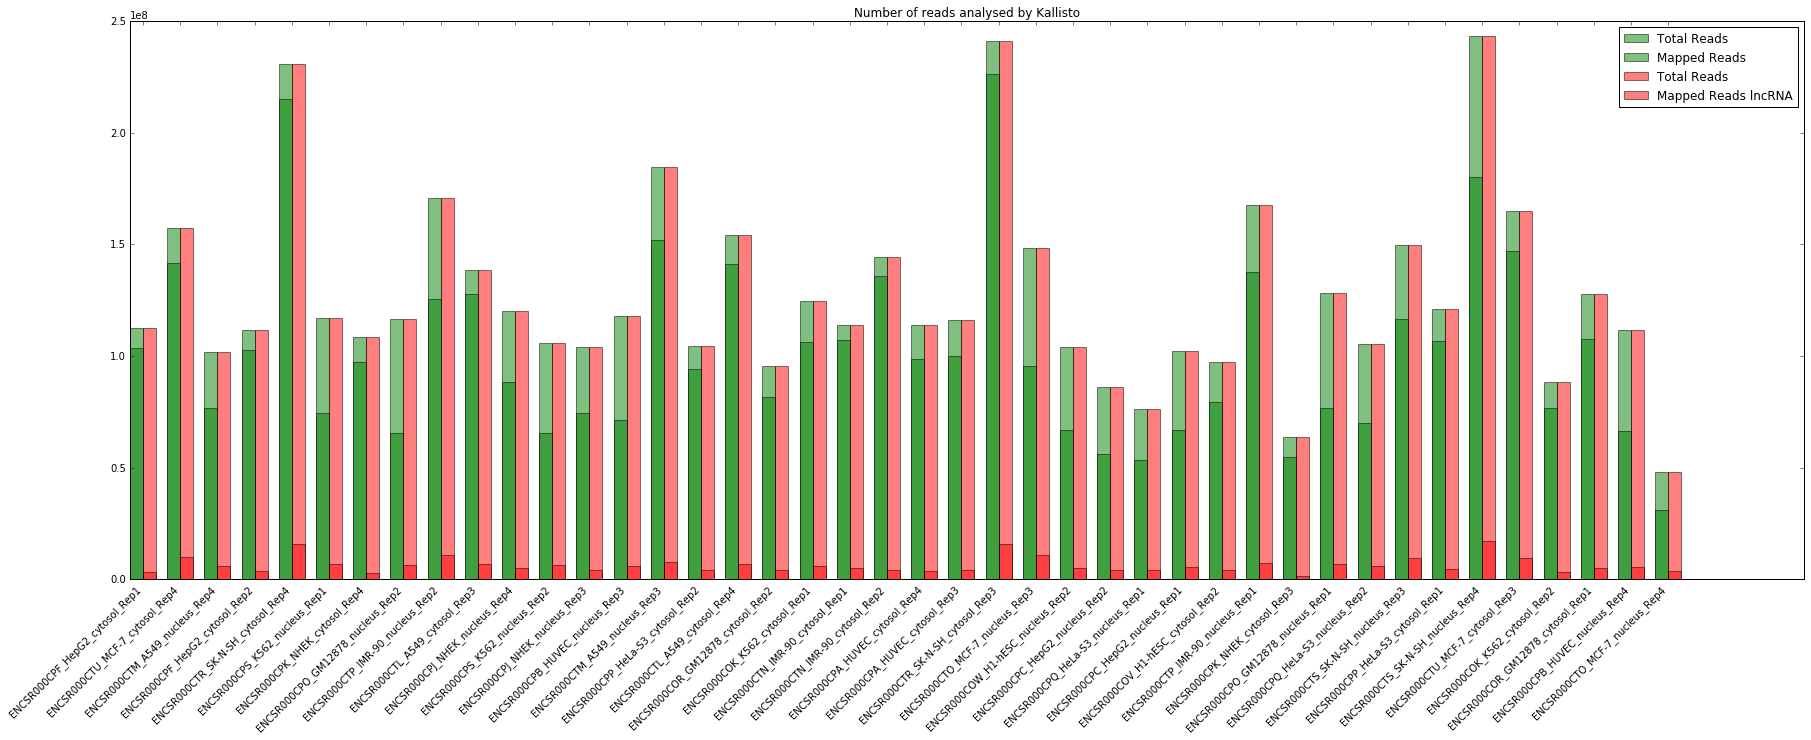

In [12]:
# Plot the results
index = np.arange(len(sname_list))
bar_width = 0.35

p1 = pl.bar(index, total_list, bar_width, color="green", alpha=0.5)
p2 = pl.bar(index, mapped_list, bar_width, color="green", alpha=0.5)
p3 = pl.bar(index+bar_width, total_lnc_list, bar_width, color="red", alpha=0.5)
p4 = pl.bar(index+bar_width, mapped_lnc_list, bar_width, color="red", alpha=0.5)

pl.xticks(index+bar_width, sname_list, rotation=45, horizontalalignment ="right")
pl.legend((p1[0], p2[0], p3[0], p4[0]), ('Total Reads', 'Mapped Reads','Total Reads', 'Mapped Reads lncRNA'))
pl.title("Number of reads analysed by Kallisto")
pl.show()

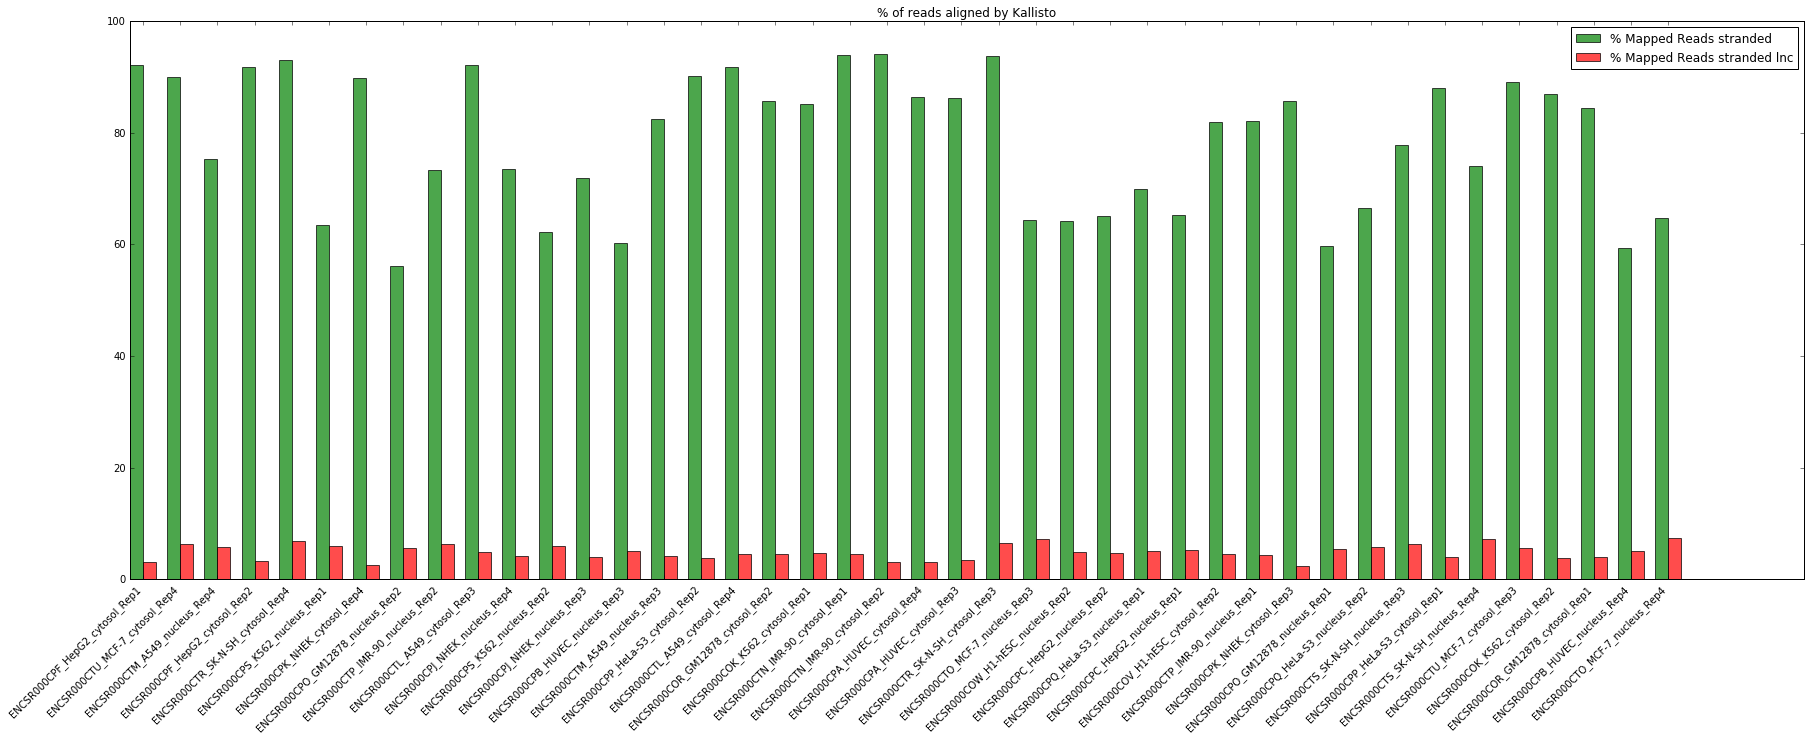

In [13]:
# Plot the results
index = np.arange(len(sname_list))
bar_width = 0.35

percent_unstrand = [mapped/total*100.0 for mapped, total in zip(mapped_list, total_list)]
percent_strand = [mapped/total*100.0 for mapped, total in zip(mapped_lnc_list, total_lnc_list)]
    
p1 = pl.bar(index, percent_unstrand, bar_width, color="green", alpha=0.7)
p2 = pl.bar(index+bar_width, percent_strand, bar_width, color="red", alpha=0.7)

pl.xticks(index+bar_width, sname_list, rotation=45, horizontalalignment ="right")
pl.legend((p1[0], p2[0]), ('% Mapped Reads stranded', '% Mapped Reads stranded lnc'))
pl.title("% of reads aligned by Kallisto")
pl.show()

**I obtained between 4E7 and 2.3E8 reads aligned (ie 60% and 90%). The stranded alignment results in less aligned reads but it is surely more accurate, so I will use only these results.**

**I also did the alignments against an index that do not contain the ERCC references with similar results for the other transcripts**

### Sleuth differencial expression analysis

**For the analysis with Sleuth I 

The first step would be to normalize the count using the ERCC standard spikes results. There are several way to find it but I need to find one that is compatible with kalisto

**Create a file containing the name of samples, the biological replicate group, and the path to the dir containing kallisto results** 

In [13]:
## Other strategy = collect informations to create a file first with python and use R after from the file.

# general library import
from os.path import abspath, basename, isdir
from glob import glob

# Function ro parse each dir and create a sample file
def sleuth_sample_list (dir, list_file="./list_file.tsv"):
    
    with open (list_file, "w") as outfp:
        outfp.write("sample\tcondition\tpath\n")

        for subdir in [path for path in glob(dir+"/*") if isdir(path)]:   
            outfp.write("{}\t{}\t{}\n".format(
                basename(subdir),
                "_".join(basename(subdir).split("_")[1:-1]),
                abspath(subdir)))

# Iterate over the directories of each cell line and create a list for each of them
basedir = "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto_results_stranded_b100/"
for dir in [path for path in glob(basedir+"*") if isdir(path)]:
    list_file = dir+"/list_file.tsv"
    sample_list = sleuth_sample_list(dir, list_file)
    !head {list_file}


sample	condition	path
ENCSR000CPO_GM12878_nucleus_Rep2	GM12878_nucleus	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto_results_stranded_b100/GM12878/ENCSR000CPO_GM12878_nucleus_Rep2
ENCSR000COR_GM12878_cytosol_Rep2	GM12878_cytosol	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto_results_stranded_b100/GM12878/ENCSR000COR_GM12878_cytosol_Rep2
ENCSR000CPO_GM12878_nucleus_Rep1	GM12878_nucleus	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto_results_stranded_b100/GM12878/ENCSR000CPO_GM12878_nucleus_Rep1
ENCSR000COR_GM12878_cytosol_Rep1	GM12878_cytosol	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto_results_stranded_b100/GM12878/ENCSR000COR_GM12878_cytosol_Rep1
sample	condition	path
ENCSR000CTU_MCF-7_cytosol_Rep4	MCF-7_cytosol	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto_results_

In [2]:
# general library import
from os.path import abspath, basename, isdir
from glob import glob

# Function ro parse each dir and  create a sample file
def sleuth_sample_list (basedir):
    
    list_file = basedir+"list_file.tsv"
    
    with open (list_file, "w") as outfp:
        outfp.write("sample\tcell_type\tlocalization\tpath\n")

        for subdir in [path for path in glob(basedir+"/*") if isdir(path)]:
            ss = basename(subdir).split("_")
            outfp.write("{}\t{}\t{}\t{}\n".format ("{}_{}".format(ss[0], ss[3]), ss[1], ss[2], abspath(subdir)))
    
    return list_file

In [3]:
basedir = "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/"
list_file = sample_list = sleuth_sample_list(basedir)
head (list_file, 2)

sample	cell_type	localization	path
ENCSR000CPF_Rep1	HepG2	cytosol	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/ENCSR000CPF_HepG2_cytosol_Rep1



In [6]:
basedir = "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA/"
list_file = sample_list = sleuth_sample_list(basedir)
head (list_file, 2)

sample	cell_type	localization	path
ENCSR000CPF_Rep1	HepG2	cytosol	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA/ENCSR000CPF_HepG2_cytosol_Rep1



**Analyse with Sleuth restricted to 3 bootstraps**

In [5]:
################## R KERNEL ##################

# Imports and setups
library("sleuth")
options(mc.cores = 4L)

sample_list = "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/list_file.tsv"
transcript_info = "../../Reference_Genomes/gencode_v24_lncRNA_transcripts_info.tsv"

# Import the file in a table
s2c = read.table(sample_list, header = TRUE, stringsAsFactors=FALSE)
s2c = subset(s2c, cell_type == "HepG2")
s2c

# Import the gene info in table and rename the fields for Sleuth compatibility
t2g = read.table(transcript_info, header = TRUE, stringsAsFactors=FALSE)
t2g = dplyr::rename(t2g, target_id = GENCODE_transcript_id, ens_gene = GENCODE_gene_id)

,sample,cell_type,localization,path
1,ENCSR000CPF_Rep1,HepG2,cytosol,/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/ENCSR000CPF_HepG2_cytosol_Rep1
4,ENCSR000CPF_Rep2,HepG2,cytosol,/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/ENCSR000CPF_HepG2_cytosol_Rep2
27,ENCSR000CPC_Rep2,HepG2,nucleus,/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/ENCSR000CPC_HepG2_nucleus_Rep2
29,ENCSR000CPC_Rep1,HepG2,nucleus,/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/ENCSR000CPC_HepG2_nucleus_Rep1


In [7]:
run_analysis <- function(data, cell_type) {

    # Extract the data from the kallisto results, LIMIT to 3 because for 100 the kernel get killed !!
    so = sleuth_prep(s2c, ~ localization, max_bootstrap=10, target_mapping = t2g)

    # Estimate parameters for the sleuth response error measurement (full) model
    so <- sleuth_fit(so)

    # Estimate parameters for the sleuth reduced model (shrinkage)
    so <- sleuth_fit(so, ~1, 'reduced')

    # Performing Wald test for to compare nucleus loc vs cytoplasm 
    so <- sleuth_wt(so, which_beta = 'localizationnucleus', 'full')

    # Perform likelihood ratio test
    so <- sleuth_lrt(so, 'reduced', 'full')

    # Save all the results in a table
    results_table <- sleuth_results(so, 'reduced:full', test_type = 'lrt')
    write.table(results_table, file = "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/DE_Sleuth.tsv",row.names=TRUE, na="",col.names=TRUE, sep="\t")

    # Save the Sleuth object for further analysis
    saveRDS(so, file = './Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/DE_Sleuth.rds')
}

reading in kallisto results
....
normalizing est_counts
11896 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps
shrinkage estimation
computing variance of betas
shrinkage estimation
computing variance of betas


	sleuth object

bears: 4 
design: ~localization 


In [ ]:
# start a shinny web server to explore the data
so = readRDS("./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/DE_Sleuth.rds")
sleuth_live(so)

Loading required package: shiny

Listening on http://127.0.0.1:42427
Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containing missing values (geom_point).Warning message:
: Removed 37 rows containi

**This is working OK but I will need to find a way to normalize between sample using a method more advanced that the one offered by Sleuth. In addition the transcript for the ERCC spike need to be used for this normalisation but removed from the final analysis.Finally I have to include the gene level analysis if I want to compare with the other methods at some point. The analysis could be a little long and needs more CPU and RAM that what is available on my laptop so I will probably have to write a small R script to run it on the cluster at the end of the day** 

---
# RNA protein interaction datasets

## Hendrickson = fRIP with 24 chromatin related protein

***Hendrickson D G, DR Kelley, D Tenen, B Bernstein, JL Rinn. Widespread RNA binding by chromatin-associated proteins.. Genome Biol 17, 28 (2016).***

- Formaldehyde RNA immunoprecipitation of 24 RPB and chromatin related proteins 
- Really detaillled and extensive datasets to have transcriptome wide lncRNA interacting with chromatin.
- Contain all the list of lncRNA gene significantly enriched in captured factions
- Problem = K562 (myelogenous leukemia line) with highly rearranged genomes... 

---
## Li  / Starbase =  CLIP-Seq data

***JH Li, S Liu, LL Zheng, J Wu, WJ Sun, ZL Wang, H Zhou, LH Qu, JH Yang. Discovery of Protein-lncRNA Interactions by Integrating Large-Scale CLIP-Seq and RNA-Seq Datasets.. Front Bioeng Biotechnol 2, 88 (2014).***

***JH Li, S Liu, H Zhou, LH Qu, JH Yang. starBase v2.0: decoding miRNA-ceRNA, miRNA-ncRNA and protein-RNA interaction networks from large-scale CLIP-Seq data.. Nucleic Acids Res 42, D92-7 (2014).***

- Comprehensive collection of lncRNA protein interaction from 
- Database dates from 2014 => contain datasets up to 2013 = not up to date.
- No specific chromatin protein => have to be crossmatched with protein localization => Done from uniprot = few nuclei pure proteins

**Cross-match Protein location Uniprot with data protein/lncRNA database from Starbase**

Selection of a limited number of candidate CLIP-Seq datasets based on their localization and the experimental conditions:
- Nuclear candidates: ALKBH5, ZC3H7B, FUS, TAF15, hnRNPC, DGCR8, FUS
- Cytoplasmic candidates: AGO1, AGO3, AGO4, FXR1, LIN28B, PUM2